In [ ]:
!pip install pydicom monai matplotlib

In [ ]:
!pip install "numpy==1.26.4" "pandas==1.5.3"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Using device: cuda
[INFO] Loaded 10239 DICOM file paths from '/content/drive/MyDrive/dcm_files.txt'.
[INFO] Loaded metadata with 2864 records from cache.

Sample data statistics:
Total samples: 2864
Pathology distribution: {'MALIGNANT': 1181, 'BENIGN': 1105, 'BENIGN_WITHOUT_CALLBACK': 578}
Columns: ['image_path', 'label', 'pathology', 'subtlety', 'breast_density', 'assessment', 'abnormality_type', 'patient_id', 'breast', 'view', 'mass_shape', 'mass_margins', 'calc_type', 'calc_distribution']
Created dataloaders: Train (2291 samples), Val (286 samples), Test (287 samples)

Creating model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Model Architecture:
patch_embed: PatchEmbed
layers: Sequential
norm: LayerNorm
head: ClassifierHead
[INFO] Successfully loaded model from /content/drive/MyDrive/best_mammo_model.pth


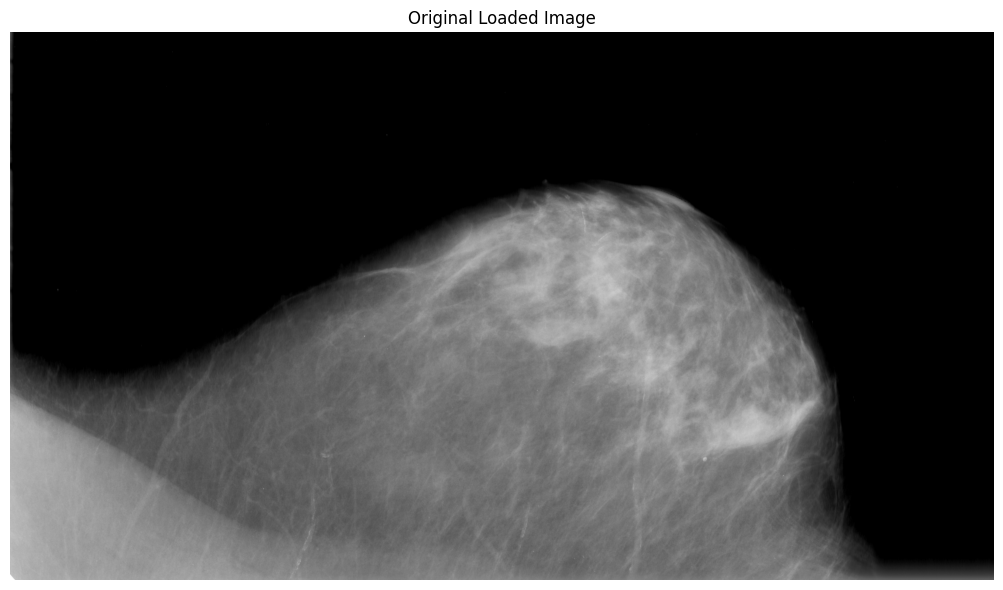

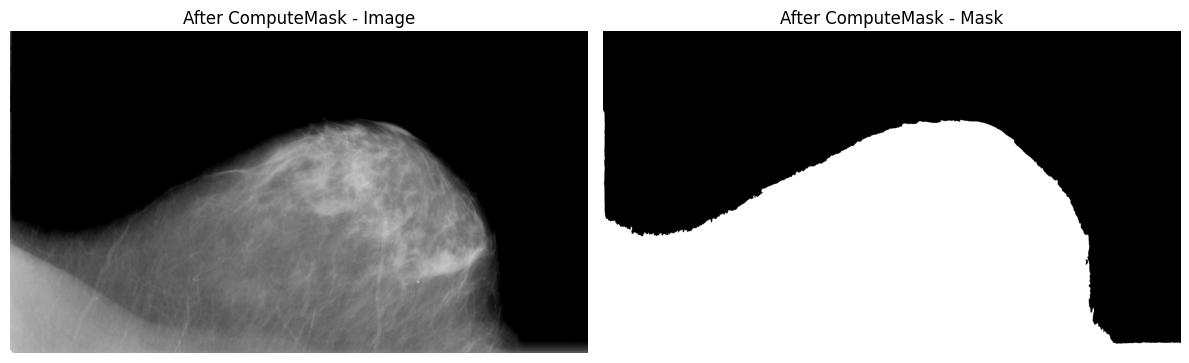

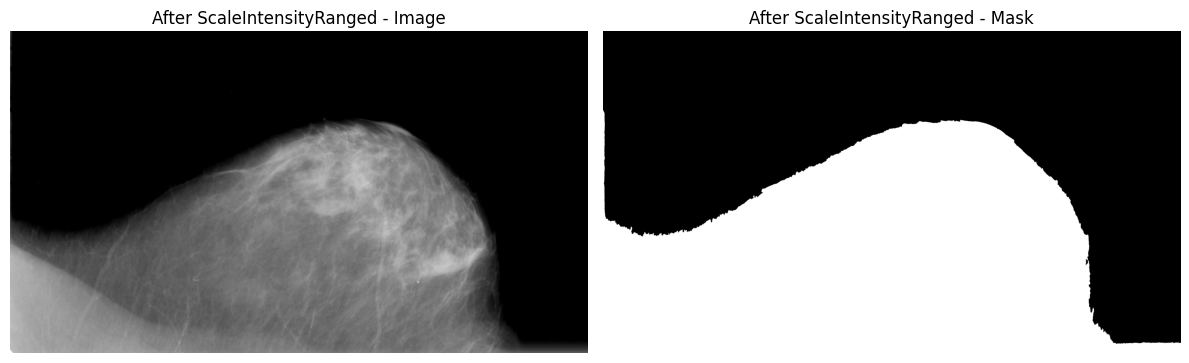

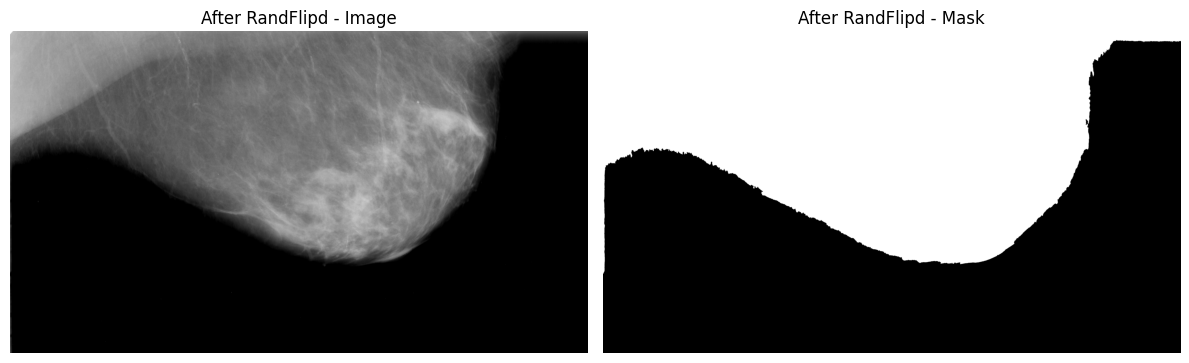

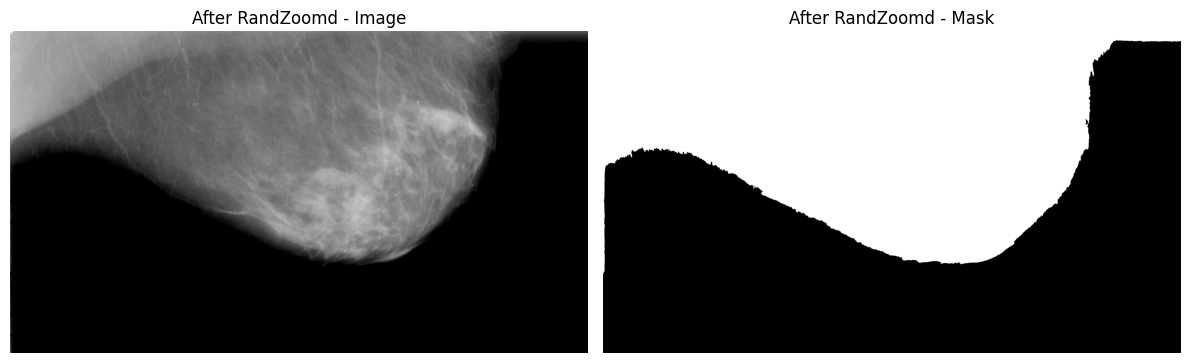

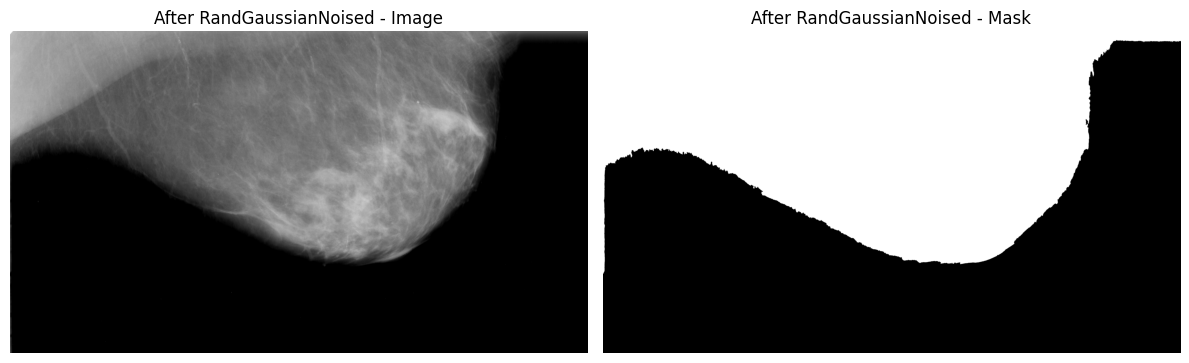

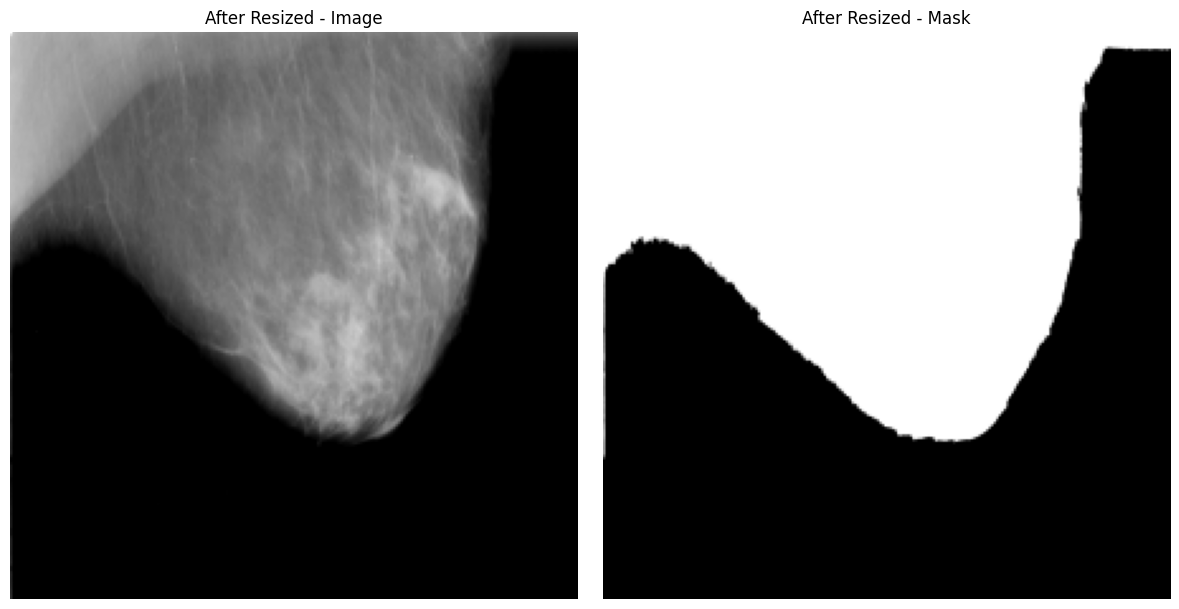

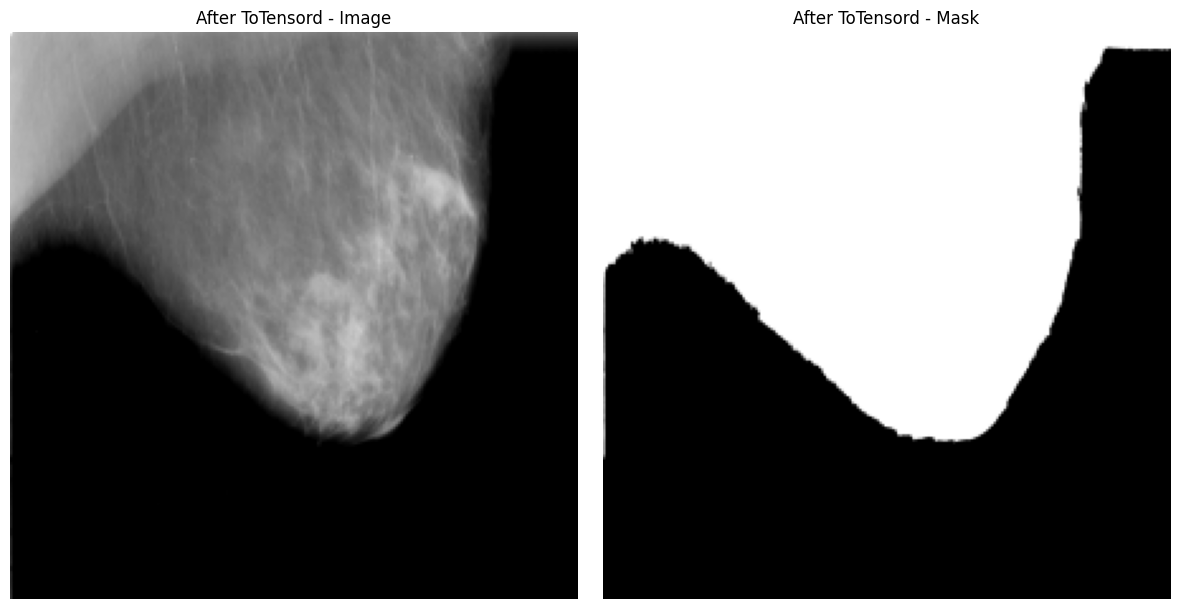

Completed step-by-step transform visualization.

Evaluating model performance...
Test Accuracy: 0.7282
ROC AUC: 0.7790

Classification Report:
              precision    recall  f1-score   support

      Benign       0.82      0.71      0.76       173
   Malignant       0.63      0.76      0.69       114

    accuracy                           0.73       287
   macro avg       0.72      0.73      0.72       287
weighted avg       0.74      0.73      0.73       287



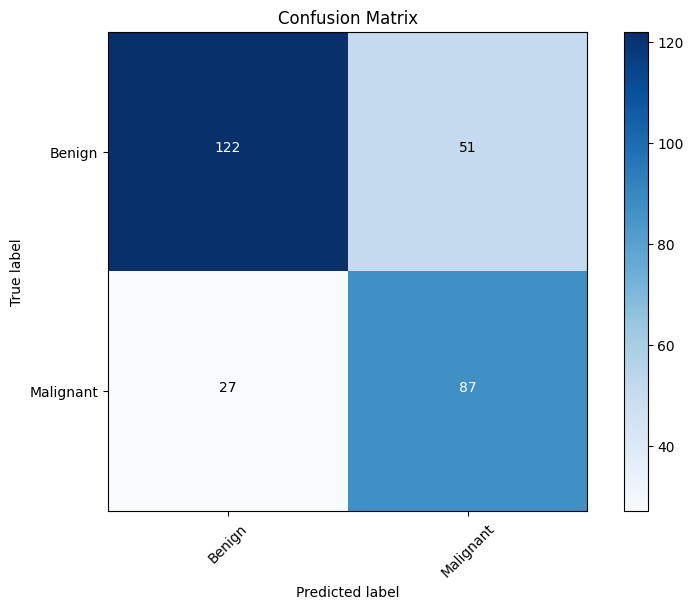

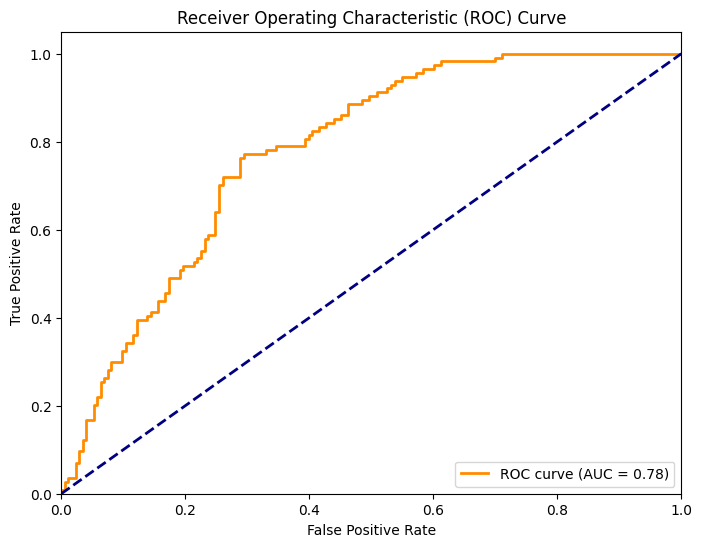

Final Accuracy: 0.7282
ROC AUC: 0.7790

Training and evaluation complete!


In [2]:
import os
import sys
import glob
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

import cv2
from scipy import ndimage
from skimage import filters, morphology, measure

import monai
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityRanged,
    RandFlipd,
    RandZoomd,
    RandGaussianNoised,
    Resized,
    ToTensord,
    MapTransform,
    Compose
)

try:
    import timm
except ImportError:
    print("Installing timm package...")
    !pip install timm
    import timm

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#########################################################
# 1) DATASET CLASSES
#########################################################

class ComputeMask(MapTransform):
    def __init__(self, keys, threshold=0.01):
        super().__init__(keys)
        self.threshold = threshold

    def segment_breast(self, image):
        image = image.astype(np.float32)
        if image.max() > 0:
            image = image / max(1e-8, image.max())
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        enhanced = clahe.apply((image * 255).astype(np.uint8))
        enhanced = enhanced.astype(np.float32) / 255.0
        thresh_1 = filters.threshold_otsu(enhanced)
        binary_1 = enhanced > thresh_1
        dark_regions = enhanced[enhanced <= thresh_1]
        if len(dark_regions) > 0:
            thresh_2 = filters.threshold_otsu(dark_regions)
            binary_2 = enhanced > thresh_2
            binary = np.logical_or(binary_1, binary_2)
        else:
            binary = binary_1
        binary = morphology.remove_small_objects(binary, min_size=1000)
        binary = morphology.remove_small_holes(binary, area_threshold=1000)
        labels = measure.label(binary)
        props = measure.regionprops(labels)
        if props:
            largest_region = max(props, key=lambda p: p.area)
            binary = (labels == largest_region.label)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        binary = cv2.dilate(binary.astype(np.uint8), kernel, iterations=2)
        binary = cv2.erode(binary.astype(np.uint8), kernel, iterations=1)
        binary = ndimage.binary_fill_holes(binary).astype(np.float32)
        return binary

    def __call__(self, data):
        for key in self.keys:
            img = data[key].clone()
            if img.ndim == 3 and img.shape[0] == 1:
                mask_1ch = self.segment_breast(img[0].clone())
                data["mask"] = torch.tensor(mask_1ch, dtype=torch.float32).unsqueeze(0)
            else:
                raise ValueError("Expected single-channel shape [1, H, W].")
        return data

class MammoMetadataDataset(Dataset):
    def __init__(self, metadata_df, transform=None):
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        image_path = row['image_path']
        label_dict = {
            'mass_calc': row['label'],
            'pathology': row['pathology'],
            'subtlety': row['subtlety'],
            'breast_density': row['breast_density'],
            'assessment': row['assessment'],
            'abnormality_type': row['abnormality_type']
        }
        data = {'image': image_path}
        if self.transform:
            try:
                loader = LoadImaged(keys='image', ensure_channel_first=True)
                data = loader(data)
                data = self.transform(data)
                img = data['image']
                if img.ndim != 3 or img.shape[0] != 1 or img.shape[1:] != (224, 224):
                    raise ValueError(f"Unexpected image shape: {img.shape}")
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")
                raise
        else:
            loader = LoadImaged(keys='image', ensure_channel_first=True)
            data = loader(data)
            img = data['image']
            mask = (img > 0.01).float()
            data = {'image': img, 'mask': mask}
        data['labels'] = label_dict
        return data

def custom_collate(batch):
    images = torch.stack([item['image'] for item in batch])
    masks = torch.stack([item['mask'] for item in batch])
    if 'labels' in batch[0]:
        labels = [item['labels'] for item in batch]
        collated_labels = {key: [d[key] for d in labels] for key in labels[0].keys()}
        return images, masks, collated_labels
    return images, masks

# Function to visualize image and mask
def plot_image_and_mask(image_tensor, mask_tensor=None, title="Mammogram"):
    if hasattr(image_tensor, 'detach'):
        image = image_tensor.detach().cpu().squeeze().numpy()
    else:
        image = image_tensor.squeeze()

    fig, axs = plt.subplots(1, 2 if mask_tensor is not None else 1, figsize=(12, 6))

    if mask_tensor is not None:
        if hasattr(mask_tensor, 'detach'):
            mask = mask_tensor.detach().cpu().squeeze().numpy()
        else:
            mask = mask_tensor.squeeze()

        axs = axs if isinstance(axs, np.ndarray) else [axs]
        axs[0].imshow(image, cmap='gray')
        axs[0].set_title(f"{title} - Image")
        axs[0].axis('off')

        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title(f"{title} - Mask")
        axs[1].axis('off')
    else:
        axs.imshow(image, cmap='gray')
        axs.set_title(title)
        axs.axis('off')

    plt.tight_layout()
    plt.show()

# Function to visualize transformation sequence
def debug_transform_sequence(single_dcm_path):
    data = {'image': single_dcm_path}
    loader = LoadImaged(keys='image', ensure_channel_first=True)
    data = loader(data)

    # Visualize original loaded image
    plot_image_and_mask(data['image'], None,
                       title="Original Loaded Image")

    # Define transformation sequence
    transform_sequence = [
        ComputeMask(keys=['image'], threshold=0.01),
        ScaleIntensityRanged(keys='image', a_min=0, a_max=65535, b_min=0.0, b_max=1.0, clip=True),
        RandFlipd(keys=['image', 'mask'], prob=0.5, spatial_axis=0),
        RandZoomd(keys=['image', 'mask'], min_zoom=0.9, max_zoom=1.1, prob=0.3),
        RandGaussianNoised(keys='image', prob=0.2),
        Resized(keys=['image', 'mask'], spatial_size=(224, 224)),
        ToTensord(keys=['image', 'mask'])
    ]

    # Apply each transform and visualize the result
    for idx, t in enumerate(transform_sequence, start=1):
        data = t(data)
        plot_image_and_mask(data['image'], data.get('mask', None),
                           title=f"After {t.__class__.__name__}")

    print("Completed step-by-step transform visualization.")

#########################################################
# 2) DATA LOADING FUNCTIONS
#########################################################

def find_full_mammogram(dcm_files, patient_folder=None):
    if patient_folder:
        return [dcm_path for dcm_path in dcm_files if patient_folder in dcm_path and "full mammogram images" in dcm_path]
    return [dcm_path for dcm_path in dcm_files if "full mammogram images" in dcm_path]

def process_dataframe(df, dcm_files, is_mass=True):
    prefix = "Mass-Training" if is_mass else "Calc-Training"
    density_col = 'breast_density' if is_mass else 'breast density'
    data = []
    for _, row in df.iterrows():
        patient_id = row['patient_id'].split('_')[1]
        breast = row['left or right breast']
        view = row['image view']
        folder_pattern = f"{prefix}_P_{patient_id}_{breast}_{view}"
        full_image_path = find_full_mammogram(dcm_files, folder_pattern)
        if full_image_path:
            item = {
                'image_path': full_image_path[0],
                'label': 1 if is_mass else 0,
                'pathology': row['pathology'],
                'subtlety': row['subtlety'],
                'breast_density': row[density_col],
                'assessment': row['assessment'],
                'abnormality_type': row['abnormality type'],
                'patient_id': row['patient_id'],
                'breast': breast,
                'view': view
            }
            if is_mass:
                item['mass_shape'] = row['mass shape']
                item['mass_margins'] = row['mass margins']
            else:
                item['calc_type'] = row['calc type']
                item['calc_distribution'] = row['calc distribution']
            data.append(item)
    return data

def parse_ddsm_metadata(root_dir, cache_dir_cls, dcm_files, force_recompute=False):
    # Check if cached metadata exists
    cache_file = os.path.join(cache_dir_cls, 'metadata_df_cls.pkl')
    if not force_recompute and os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            metadata_df = pickle.load(f)
        print(f"[INFO] Loaded metadata with {len(metadata_df)} records from: {cache_file}")
        return metadata_df

    # Load and process the CSV files
    mass_train_csv = os.path.join(root_dir, 'mass_case_description_train_set.csv')
    mass_test_csv = os.path.join(root_dir, 'mass_case_description_test_set.csv')
    calc_train_csv = os.path.join(root_dir, 'calc_case_description_train_set.csv')
    calc_test_csv = os.path.join(root_dir, 'calc_case_description_test_set.csv')

    mass_train = pd.read_csv(mass_train_csv)
    mass_test = pd.read_csv(mass_test_csv)
    calc_train = pd.read_csv(calc_train_csv)
    calc_test = pd.read_csv(calc_test_csv)

    all_data = []
    all_data.extend(process_dataframe(mass_train, dcm_files, is_mass=True))
    all_data.extend(process_dataframe(mass_test, dcm_files, is_mass=True))
    all_data.extend(process_dataframe(calc_train, dcm_files, is_mass=False))
    all_data.extend(process_dataframe(calc_test, dcm_files, is_mass=False))

    metadata_df = pd.DataFrame(all_data)

    # Cache the processed metadata
    os.makedirs(os.path.dirname(cache_file), exist_ok=True)
    with open(cache_file, 'wb') as f:
        pickle.dump(metadata_df, f)

    print(f"[INFO] Processed and cached metadata with {len(metadata_df)} records to {cache_file}")
    return metadata_df

def create_dataloaders(metadata_df, batch_size=4, num_workers=2, missing_label_percentage=100, seed=42):
    # Define transforms for the dataset
    transform = Compose([
        ComputeMask(keys=['image'], threshold=0.01),
        ScaleIntensityRanged(keys='image', a_min=0, a_max=65535, b_min=0.0, b_max=1.0, clip=True),
        RandFlipd(keys=['image', 'mask'], prob=0.5, spatial_axis=0),
        RandZoomd(keys=['image', 'mask'], min_zoom=0.9, max_zoom=1.1, prob=0.3),
        RandGaussianNoised(keys='image', prob=0.2),
        Resized(keys=['image', 'mask'], spatial_size=(224, 224)),
        ToTensord(keys=['image', 'mask'])
    ])

    # Create dataset
    dataset = MammoMetadataDataset(metadata_df, transform=transform)

    # Split dataset
    total_size = len(dataset)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(seed)
    )

    # Apply missing_label_percentage if specified
    if missing_label_percentage < 100:
        num_samples = int(missing_label_percentage / 100.0 * train_size)
        indices = torch.randperm(train_size)[:num_samples]
        train_dataset = Subset(train_dataset, indices)
        print(f"[CLS] Using {missing_label_percentage}% labeled training => {len(train_dataset)} samples.")

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=custom_collate
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=custom_collate
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=custom_collate
    )

    return train_loader, val_loader, test_loader

#########################################################
# 3) UTILS: CLASS WEIGHTS, LABEL CONVERSION
#########################################################

# Helper function to convert pathology to numeric labels
def convert_pathology_to_label(pathology_list):
    numeric_labels = []
    for p in pathology_list:
        if isinstance(p, str) and p.upper().startswith('MAL'):
            numeric_labels.append(1)  # Malignant
        else:
            numeric_labels.append(0)  # Benign
    return torch.tensor(numeric_labels, dtype=torch.long).to(device)

def compute_class_weights(metadata_df):
    pathology_counts = metadata_df['pathology'].value_counts()
    benign_count = pathology_counts.get('BENIGN', 0) + pathology_counts.get('BENIGN_WITHOUT_CALLBACK', 0)
    malignant_count = pathology_counts.get('MALIGNANT', 0)

    benign_count = max(benign_count, 1)
    malignant_count = max(malignant_count, 1)
    total_samples = benign_count + malignant_count

    weight_benign = total_samples / (2.0 * benign_count)
    weight_malignant = total_samples / (2.0 * malignant_count)
    return torch.tensor([weight_benign, weight_malignant], dtype=torch.float)

#########################################################
# 4) TRAIN-EVAL FUNCTION
#########################################################

def train_and_evaluate(
    model,
    train_loader,
    val_loader,
    test_loader,
    class_weights=None,
    num_epochs=5,
    lr=1e-4,
    weight_decay=1e-5,
    save_dir="/content/drive/MyDrive/"
):
    """
    Train and evaluate a model

    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        test_loader: DataLoader for test data
        class_weights: Class weights for handling imbalance
        num_epochs: Number of training epochs
        lr: Learning rate
        weight_decay: Weight decay for regularization
        save_dir: Directory to save the best model checkpoint
    """
    if class_weights is None:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Metrics tracking
    train_losses = []
    train_accs = []
    val_accs = []
    test_accs = []

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # ----------------------- TRAIN -----------------------
        model.train()
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0

        for batch_idx, (imgs, masks, label_dict) in enumerate(train_loader):
            imgs = imgs.to(device)
            labels = convert_pathology_to_label(label_dict['pathology'])

            optimizer.zero_grad()

            logits = model(imgs)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            preds = logits.argmax(dim=1)

            epoch_loss += loss.item() * imgs.size(0)
            epoch_correct += (preds == labels).sum().item()
            epoch_total += imgs.size(0)

        avg_train_loss = epoch_loss / epoch_total if epoch_total else 0
        train_acc = epoch_correct / epoch_total if epoch_total else 0
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # ----------------------- VALIDATION -----------------------
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for imgs, masks, ld in val_loader:
                imgs = imgs.to(device)
                lbls = convert_pathology_to_label(ld['pathology'])
                logits = model(imgs)
                preds = logits.argmax(dim=1)
                val_correct += (preds == lbls).sum().item()
                val_total += imgs.size(0)
        val_acc = val_correct / val_total if val_total else 0
        val_accs.append(val_acc)

        # ----------------------- TEST -----------------------
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for imgs, masks, ld in test_loader:
                imgs = imgs.to(device)
                lbls = convert_pathology_to_label(ld['pathology'])
                logits = model(imgs)
                preds = logits.argmax(dim=1)
                test_correct += (preds == lbls).sum().item()
                test_total += imgs.size(0)
        test_acc = test_correct / test_total if test_total else 0
        test_accs.append(test_acc)

        # ----------------------- LOG EPOCH -----------------------
        print(f"\n[Epoch {epoch+1}/{num_epochs}]"
              f" Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} || "
              f"Val Acc: {val_acc:.4f} || Test Acc: {test_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

            # Save the model to disk
            model_save_path = os.path.join(save_dir, "best_mammo_model.pth")
            torch.save(model.state_dict(), model_save_path)
            print(f"  [*] New best Val Acc: {best_val_acc:.4f}")
            print(f"  [*] Saved model to: {model_save_path}")

    # ----------------------- PLOTS -----------------------
    epochs_range = range(1, num_epochs+1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, train_accs, 'b-', label='Train Accuracy')
    plt.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy')
    plt.plot(epochs_range, test_accs, 'g-', label='Test Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Load best model for final evaluation
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_accs': test_accs,
        'best_val_acc': best_val_acc,
        'best_model_state': best_model_state
    }

#########################################################
# 5) STANDARD EVALUATION FUNCTION
#########################################################

def evaluate_model(model, test_loader, verbose=True):
    """
    Evaluate model performance on pathology classification task
    """
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (imgs, masks, label_dict) in enumerate(test_loader):
            imgs = imgs.to(device)
            labels = convert_pathology_to_label(label_dict['pathology'])

            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of malignant class
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    cr = classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant'], output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)

    # ROC curve and AUC
    try:
        roc_auc = roc_auc_score(all_labels, all_probs)
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
    except:
        roc_auc = None
        fpr, tpr = None, None

    results = {
        'accuracy': accuracy,
        'classification_report': cr,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'roc_curve': (fpr, tpr)
    }

    if verbose:
        print(f"Test Accuracy: {accuracy:.4f}")
        if roc_auc is not None:
            print(f"ROC AUC: {roc_auc:.4f}")
        else:
            print("ROC AUC: N/A")

        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
        plt.yticks(tick_marks, ['Benign', 'Malignant'])

        # Add text annotations to confusion matrix
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

        # Plot ROC curve if available
        if roc_auc is not None:
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.show()

    return results

#########################################################
# 6) EXECUTION
#########################################################

# Configuration parameters
root_dir = "/content/drive/MyDrive/cbis-ddsm-data"  # Update this path to your DDSM dataset
# Optional: Path to cache that stores metadata, set to None to generate from scratch
cache_dir_cls = "/content/drive/MyDrive"  # Update to your cache directory
# Optional: Path to file containing DICOM paths, set to None to scan directory for DICOM files
dicom_path = "/content/drive/MyDrive/dcm_files.txt"  # Path to file containing DICOM paths
save_dir = "/content/drive/MyDrive/"  # Directory to save model checkpoints
batch_size = 4
num_workers = 2
num_epochs = 3

# Optional: Path to a pre-trained model, set to None to train from scratch
model_path = "/content/drive/MyDrive/best_mammo_model.pth"

# Load DICOM paths if file exists, otherwise scan directory to create the list
if dicom_path and os.path.exists(dicom_path):
    with open(dicom_path, "r") as f:
        dcm_files = [line.strip() for line in f]
    print(f"[INFO] Loaded {len(dcm_files)} DICOM file paths from '{dicom_path}'.")
else:
    generate_msg = "Generating from scratch" if dicom_path is None else f"DICOM path file '{dicom_path}' not found"
    print(f"[INFO] {generate_msg}. Scanning directory for DICOM files...")
    # Make sure the root directory exists
    if not os.path.exists(root_dir):
        raise ValueError(f"Root directory '{root_dir}' does not exist. Please set a valid root_dir path.")

    # Scan directory for DICOM files recursively
    dcm_files = glob.glob(os.path.join(root_dir, "**", "*.dcm"), recursive=True)
    print(f"[INFO] Found {len(dcm_files)} DICOM files by scanning '{root_dir}'.")

    if len(dcm_files) == 0:
        print("[WARNING] No DICOM files found in the specified directory.")
    else:
        # Save the list to dicom_path for future use (if dicom_path is provided)
        if dicom_path:
            dicom_dir = os.path.dirname(dicom_path)
            os.makedirs(dicom_dir, exist_ok=True)
            with open(dicom_path, "w") as f:
                for path in dcm_files:
                    f.write(path + "\n")
            print(f"[INFO] Saved DICOM file paths to '{dicom_path}'.")

# Load metadata from cache or parse from DDSM dataset
if cache_dir_cls:
    cache_file = os.path.join(cache_dir_cls, 'metadata_df_cls.pkl')
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            metadata_df = pickle.load(f)
        print(f"[INFO] Loaded metadata with {len(metadata_df)} records from cache.")
    else:
        print(f"[INFO] Metadata cache not found at {cache_file}. Generating metadata from scratch...")
else:
    print("[INFO] Cache directory not specified. Generating metadata from scratch...")
    # Set a temporary cache file location in the root directory
    cache_file = os.path.join(root_dir, 'metadata_df_cls.pkl')

    # Make sure cache directory exists
    if cache_dir_cls:
        os.makedirs(cache_dir_cls, exist_ok=True)
    else:
        # If no cache_dir_cls provided, we'll save to root_dir
        os.makedirs(os.path.dirname(cache_file), exist_ok=True)

    if len(dcm_files) == 0:
        raise ValueError("Cannot generate metadata: No DICOM files available. Please provide a valid directory with DICOM files.")

    # Load and process the CSV files from the root directory
    csv_files = {
        'mass_train': os.path.join(root_dir, 'mass_case_description_train_set.csv'),
        'mass_test': os.path.join(root_dir, 'mass_case_description_test_set.csv'),
        'calc_train': os.path.join(root_dir, 'calc_case_description_train_set.csv'),
        'calc_test': os.path.join(root_dir, 'calc_case_description_test_set.csv')
    }

    # Check if all required CSV files exist
    missing_files = [file for file, path in csv_files.items() if not os.path.exists(path)]
    if missing_files:
        raise ValueError(f"Cannot generate metadata: Missing required CSV files: {', '.join(missing_files)}")

    # Generate metadata using the parse_ddsm_metadata function
    metadata_df = parse_ddsm_metadata(root_dir, cache_dir_cls, dcm_files, force_recompute=True)

    # The parse_ddsm_metadata function should save the cache file, but let's make sure
    if not os.path.exists(cache_file):
        print(f"[INFO] Caching metadata to {cache_file}")
        os.makedirs(os.path.dirname(cache_file), exist_ok=True)
        with open(cache_file, 'wb') as f:
            pickle.dump(metadata_df, f)

    print(f"[INFO] Generated metadata with {len(metadata_df)} records and cached to {cache_file}")

# Sample data analysis
if 'metadata_df' in locals() and len(metadata_df) > 0:
    print("\nSample data statistics:")
    print(f"Total samples: {len(metadata_df)}")
    print(f"Pathology distribution: {metadata_df['pathology'].value_counts().to_dict()}")
    print(f"Columns: {metadata_df.columns.tolist()}")

    # Create dataloaders
    train_loader, val_loader, test_loader = create_dataloaders(
        metadata_df,
        batch_size=batch_size,
        num_workers=num_workers
    )
    print(f"Created dataloaders: Train ({len(train_loader.dataset)} samples), "
          f"Val ({len(val_loader.dataset)} samples), "
          f"Test ({len(test_loader.dataset)} samples)")
else:
    raise ValueError("Failed to load or generate metadata. Please check your dataset paths and CSV files.")

# Load or create model
print("\nCreating model...")
model = timm.create_model(
    "swin_base_patch4_window7_224",
    pretrained=True,
    in_chans=1,        # Grayscale images
    num_classes=2      # Binary classification: benign vs malignant
).to(device)

# Print model architecture summary
print("\nModel Architecture:")
for name, child in model.named_children():
    print(f"{name}: {child.__class__.__name__}")

# Try to load model if path is provided
skip_training = False
if model_path:
    try:
        model.load_state_dict(torch.load(model_path))
        print(f"[INFO] Successfully loaded model from {model_path}")
        skip_training = True
    except Exception as e:
        print(f"[WARNING] Could not load model from {model_path}: {str(e)}")
        skip_training = False  # Will train a new model

# Optional: Visualize the transformation sequence on a sample image
if len(dcm_files) > 0:
    sample_image_path = dcm_files[0]
    debug_transform_sequence(sample_image_path)

if not skip_training:
    # Compute class weights for imbalanced dataset
    class_weights = compute_class_weights(metadata_df).to(device)
    print(f"Class weights: {class_weights}")

    # Train model
    print("\nStarting model training...")
    training_results = train_and_evaluate(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        class_weights=None,
        num_epochs=num_epochs,
        lr=1e-4,
        weight_decay=1e-5,
        save_dir=save_dir
    )
    print(f"Best validation accuracy: {training_results['best_val_acc']:.4f}")

    # Save the final model
    final_model_path = os.path.join(save_dir, "final_mammo_model.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"\nSaved final model to: {final_model_path}")

# Evaluate model
print("\nEvaluating model performance...")
results = evaluate_model(model, test_loader)
print(f"Final Accuracy: {results['accuracy']:.4f}")
if results['roc_auc'] is not None:
    print(f"ROC AUC: {results['roc_auc']:.4f}")
else:
    print("ROC AUC: N/A")

print("\nTraining and evaluation complete!")

In [3]:
def get_random_sample(dataloader):

    dataset = dataloader.dataset
    random_idx = random.randint(0, len(dataset) - 1)
    sample = dataset[random_idx]

    # Handle our dataset structure which returns a dictionary with 'image', 'mask', and 'labels'
    if isinstance(sample, dict):
        image = sample['image']
        mask = sample['mask']
        labels = sample['labels']
    else:
        # For subset or other dataset wrappers
        image, mask, labels = sample
        if isinstance(labels, tuple) and len(labels) > 0:
            # Handle case where the dataset returns multiple items
            labels = labels[0]

    # Ensure labels is a dictionary with list values for batch consistency
    if isinstance(labels, dict):
        # Convert single values to lists
        labels = {k: [v] for k, v in labels.items()}
    else:
        # If it's not a dict, create a default label dict
        labels = {'pathology': [labels]}

    return image.unsqueeze(0).to(device), mask.unsqueeze(0).to(device), labels

def get_sample_by_pathology(dataloader, pathology_type='MALIGNANT', max_attempts=20):
    """
    Get a random sample of the specified pathology type using get_random_sample

    Args:
        dataloader: DataLoader object
        pathology_type: String, either 'MALIGNANT' or 'BENIGN'
        max_attempts: Maximum number of random samples to try

    Returns:
        image: Tensor of shape (1, C, H, W)
        mask: Tensor of the corresponding mask
        labels: Dictionary of labels
    """
    # Convert pathology type to uppercase for comparison
    pathology_type = pathology_type.upper()

    # Try up to max_attempts times to find a matching sample
    for _ in range(max_attempts):
        image, mask, labels = get_random_sample(dataloader)

        # Check if this sample matches the requested pathology
        if 'pathology' in labels:
            current_pathology = labels['pathology'][0].upper()
            if current_pathology.startswith(pathology_type):
                return image, mask, labels

    # If we get here, we couldn't find a matching sample
    raise ValueError(f"No {pathology_type} samples found after {max_attempts} attempts. Try increasing max_attempts.")


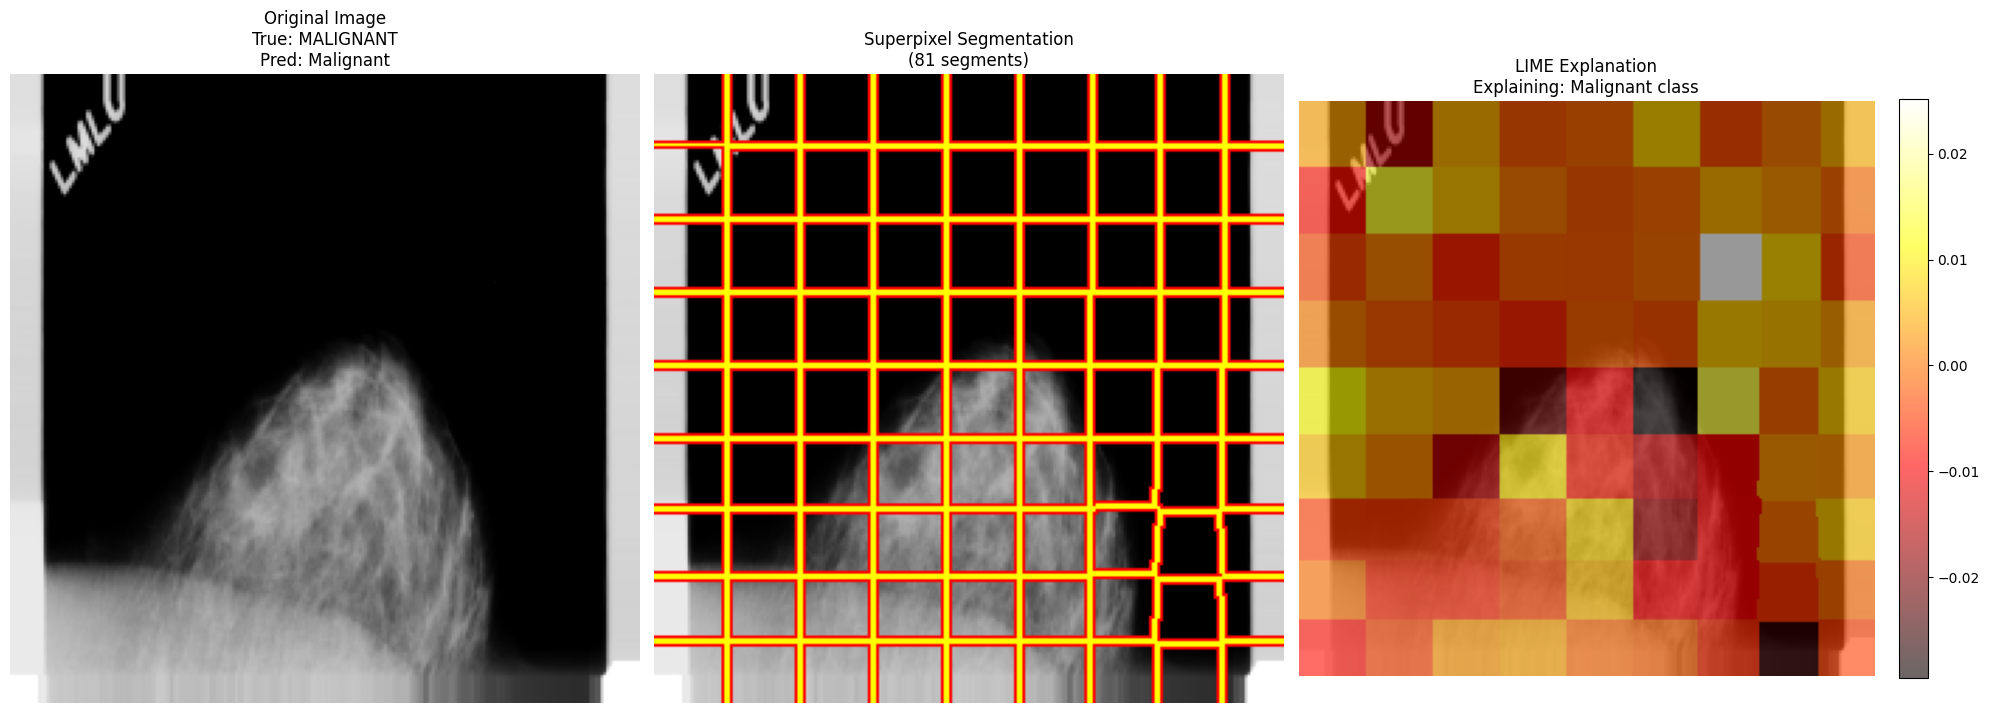

LIME (Local Interpretable Model-agnostic Explanations) for Mammography
--------------------------------------------------------------------
LIME works by:
1. Segmenting the image into superpixels
2. Creating perturbed versions by randomly masking superpixels
3. Getting model predictions for perturbed images
4. Training a linear model to approximate the complex model locally
5. Visualizing which segments are most important for the prediction


In [4]:
from skimage.segmentation import slic, mark_boundaries
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import cosine_distances
from typing import Optional, Tuple

# LIME implementation for superpixel-based explainability
class LIME:
    def __init__(self, model, n_samples=1000, n_segments=100, kernel_width=0.25):
        """
        Initialize LIME explainer for image data

        Args:
            model: The PyTorch model to explain
            n_samples: Number of perturbed samples to generate
            n_segments: Number of superpixels to generate
            kernel_width: Width of the exponential kernel used for weighting
        """
        self.model = model
        self.n_samples = n_samples
        self.n_segments = n_segments
        self.kernel_width = kernel_width
        self.device = next(model.parameters()).device

    def generate_superpixels(self, image_np):
        """Generate superpixels for the image."""
        segments = slic(image_np, n_segments=self.n_segments, compactness=10, sigma=1, start_label=0, channel_axis=None)
        return segments

    def generate_perturbed_samples(self, image_np, segments):
        """
        Generate perturbed samples by randomly masking superpixels

        Args:
            image_np: Numpy array of the image
            segments: Segmentation map from SLIC

        Returns:
            perturbed_images: List of perturbed images
            binary_masks: List of binary masks indicating which segments are active
        """
        n_segments = np.max(segments) + 1
        perturbed_images = []
        binary_masks = []

        for _ in range(self.n_samples):
            # Create a random binary mask (1 = keep segment, 0 = mask segment)
            active_segments = np.random.binomial(1, 0.5, n_segments)

            # Create a mask where 1 = keep pixel, 0 = mask pixel
            mask = np.zeros(segments.shape)
            for i in range(n_segments):
                mask[segments == i] = active_segments[i]

            # Create a perturbed image where masked areas are set to 0 (black)
            perturbed = image_np.copy() * mask

            perturbed_images.append(perturbed)
            binary_masks.append(active_segments)

        return np.array(perturbed_images), np.array(binary_masks)

    def get_predictions(self, perturbed_images):
        """
        Get model predictions for perturbed images

        Args:
            perturbed_images: List of perturbed images

        Returns:
            predictions: Model predictions for target class
        """
        batch_size = 8
        predictions = []

        self.model.eval()
        with torch.no_grad():
            for i in range(0, len(perturbed_images), batch_size):
                batch = perturbed_images[i:i+batch_size]
                # Add channel dimension and convert to tensor
                batch_tensor = torch.tensor(batch[:, np.newaxis], dtype=torch.float32).to(self.device)

                outputs = self.model(batch_tensor)

                # Get class probabilities
                probs = F.softmax(outputs, dim=1).cpu().numpy()

                # Add to predictions
                predictions.extend(probs)

        return np.array(predictions)

    def kernel_function(self, distances):
        """Apply exponential kernel to distances."""
        return np.sqrt(np.exp(-(distances**2) / self.kernel_width**2))

    def explain(self, image_tensor, target_class=None):
        """
        Generate LIME explanation for the image

        Args:
            image_tensor: PyTorch tensor of the image (1, C, H, W)
            target_class: Target class index (if None, use predicted class)

        Returns:
            explanation: Heatmap of feature importance
            segments: Superpixel segmentation
            predicted_class: Predicted class index
        """
        # Convert tensor to numpy for segmentation
        if len(image_tensor.shape) == 4:  # Batch dimension
            image_np = image_tensor[0, 0].cpu().numpy()  # Take first image, first channel
        else:
            image_np = image_tensor[0].cpu().numpy()  # Take first channel

        # Normalize image for segmentation if needed
        if image_np.min() < 0 or image_np.max() > 1:
            image_for_seg = (image_np - image_np.min()) / (image_np.max() - image_np.min())
        else:
            image_for_seg = image_np

        # Generate superpixel segmentation
        segments = self.generate_superpixels(image_for_seg)

        # If target class not specified, use predicted class
        with torch.no_grad():
            output = self.model(image_tensor)
            predicted_class = output.argmax(dim=1).item()

        if target_class is None:
            target_class = predicted_class

        # Generate perturbed samples
        perturbed_images, binary_masks = self.generate_perturbed_samples(image_np, segments)

        # Get predictions for perturbed samples
        predictions = self.get_predictions(perturbed_images)

        # Extract probabilities for target class
        target_probs = predictions[:, target_class]

        # Calculate distances between original binary mask and perturbed binary masks
        # Original mask is all 1s (all segments active)
        original_mask = np.ones(binary_masks[0].shape)
        distances = cosine_distances(binary_masks, original_mask.reshape(1, -1)).ravel()

        # Apply kernel to get sample weights
        weights = self.kernel_function(distances)

        # Train ridge regression
        regression = Ridge(alpha=1.0)
        regression.fit(binary_masks, target_probs, sample_weight=weights)

        # Get feature importances (coefficients)
        feature_importance = regression.coef_

        # Create explanation heatmap
        explanation = np.zeros(segments.shape)
        for i in range(len(feature_importance)):
            explanation[segments == i] = feature_importance[i]

        return explanation, segments, target_class, predicted_class

    def visualize(self, image_tensor, explanation, segments, true_label, target_class, predicted_class):
        """
        Visualize the LIME explanation

        Args:
            image_tensor: PyTorch tensor of the image
            explanation: Explanation heatmap
            segments: Superpixel segmentation
            true_label: True label (string)
            target_class: Target class index
            predicted_class: Predicted class index

        Returns:
            fig: Matplotlib figure
        """
        # Convert tensor to numpy for visualization
        if len(image_tensor.shape) == 4:  # Batch dimension
            image_np = image_tensor[0, 0].cpu().numpy()  # Take first image, first channel
        else:
            image_np = image_tensor[0].cpu().numpy()  # Take first channel

        # Create visualization
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

        # Original image
        ax1.imshow(image_np, cmap='gray')
        ax1.set_title(f"Original Image\nTrue: {true_label}\nPred: {'Malignant' if predicted_class == 1 else 'Benign'}")
        ax1.axis('off')

        # Segmentation
        ax2.imshow(mark_boundaries(image_np, segments, color=(1, 1, 0), outline_color=(1, 0, 0)))
        ax2.set_title(f'Superpixel Segmentation\n({len(np.unique(segments))} segments)')
        ax2.axis('off')

        # LIME explanation
        ax3.imshow(image_np, cmap='gray')
        explanation_display = ax3.imshow(explanation, cmap='hot', alpha=0.6)
        ax3.set_title(f"LIME Explanation\nExplaining: {'Malignant' if target_class == 1 else 'Benign'} class")
        ax3.axis('off')
        plt.colorbar(explanation_display, ax=ax3, fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()

        return fig

# Run LIME explanation
def run_lime_explanation(model, image, labels, n_segments=75, n_samples=500):
    """
    Run LIME explanation for a mammogram image

    Args:
        model: The model to explain
        image: Image tensor (1, C, H, W)
        labels: Dictionary of labels
        n_segments: Number of superpixels
        n_samples: Number of perturbed samples

    Returns:
        fig: Matplotlib figure with the explanation
    """
    # Get true label
    true_label = labels['pathology'][0]

    # Convert label to class index
    true_class = 1 if true_label.upper().startswith('MAL') else 0

    # Initialize LIME explainer
    lime_explainer = LIME(model, n_samples=n_samples, n_segments=n_segments)

    # Generate explanation
    explanation, segments, target_class, predicted_class = lime_explainer.explain(image, target_class=true_class)

    # Visualize explanation
    fig = lime_explainer.visualize(image, explanation, segments, true_label, target_class, predicted_class)

    return fig, explanation, segments

# Get a malignant sample
image, mask, labels = get_sample_by_pathology(test_loader, 'MALIGNANT')

# Run LIME explanation
fig, explanation, segments = run_lime_explanation(model, image, labels, n_segments=75, n_samples=300)

print("LIME (Local Interpretable Model-agnostic Explanations) for Mammography")
print("--------------------------------------------------------------------")
print("LIME works by:")
print("1. Segmenting the image into superpixels")
print("2. Creating perturbed versions by randomly masking superpixels")
print("3. Getting model predictions for perturbed images")
print("4. Training a linear model to approximate the complex model locally")
print("5. Visualizing which segments are most important for the prediction")

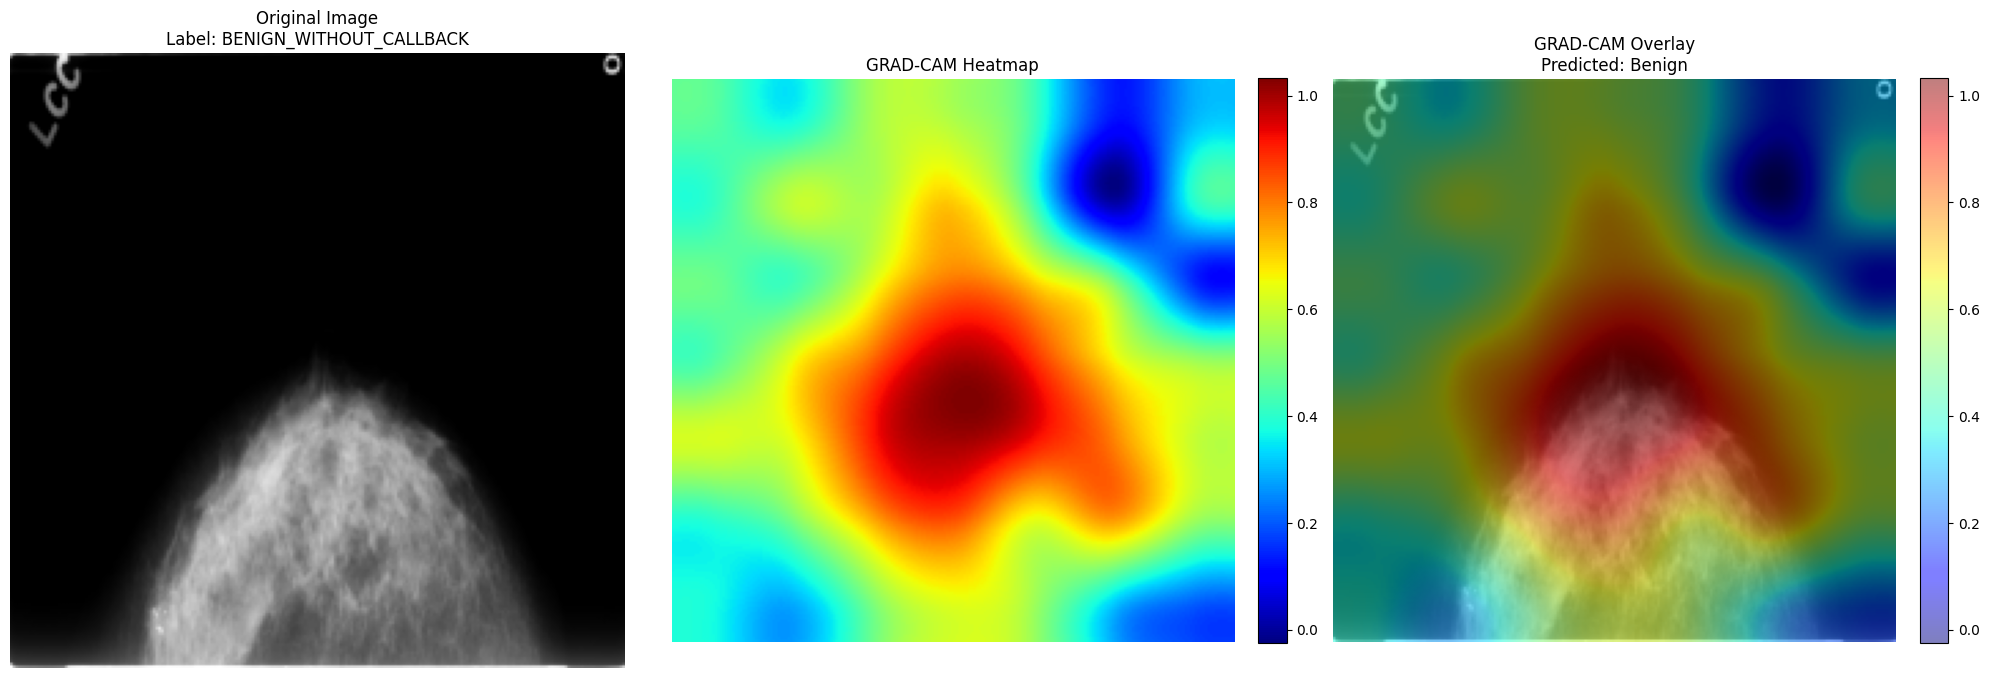

GRAD-CAM (Gradient-weighted Class Activation Mapping)
-----------------------------------------------------
GRAD-CAM works by:
1. Getting the activations of a late layer in the network
2. Computing the gradients of the target class with respect to these activations
3. Using these gradients as weights to create a weighted sum of the activations
4. Applying ReLU to highlight regions that positively influence the prediction

For transformers like Swin, we adapt this by using attention maps and their gradients


In [5]:
# Function to identify a suitable target layer for GRAD-CAM
def get_target_layer(model):
    """
    Find the appropriate layer for GRAD-CAM visualization for both CNN and Transformer models

    Args:
        model: PyTorch model (CNN or Transformer)

    Returns:
        The target layer to use for GRAD-CAM visualization
    """
    # Get the base model if it's wrapped
    if hasattr(model, 'model'):
        target_model = model.model
    elif hasattr(model, 'encoder'):
        target_model = model.encoder
    else:
        target_model = model

    # Check if the model is a transformer-based architecture
    is_transformer = any(attr for attr in ['layers', 'blocks', 'transformer', 'attention', 'swinv2']
                         if hasattr(target_model, attr))

    # Case 1: Swin Transformer from timm
    if is_transformer and hasattr(target_model, 'layers') and len(target_model.layers) > 1:
        # Get the second-to-last stage (index -2) for better localization
        stage = target_model.layers[-3]
        if hasattr(stage, 'blocks') and len(stage.blocks) > 0:
            # Get the last block in this stage
            block = stage.blocks[-1]
            # Get the attention module
            if hasattr(block, 'attn'):
                return block.attn

    # Case 2: CNN architectures
    if not is_transformer:
        # For CNNs, typically the last convolutional layer before pooling/classifier is best for GRAD-CAM

        # Check for ResNet-like architectures
        if hasattr(target_model, 'layer4') and hasattr(target_model.layer4, '__getitem__'):
            # Return the last conv layer of the last block
            return target_model.layer4[-1].conv3 if hasattr(target_model.layer4[-1], 'conv3') else target_model.layer4[-1].conv2

        # Check for VGG-like architectures
        if hasattr(target_model, 'features') and hasattr(target_model.features, '__getitem__'):
            # Find the last conv layer in the features
            for i in range(len(target_model.features)-1, -1, -1):
                if isinstance(target_model.features[i], nn.Conv2d):
                    return target_model.features[i]

        # Check for EfficientNet-like architectures
        if hasattr(target_model, 'conv_head') and isinstance(target_model.conv_head, nn.Conv2d):
            return target_model.conv_head

        # Check for MobileNet-like architectures
        if hasattr(target_model, 'blocks') and len(target_model.blocks) > 0:
            # Get the last convolutional block
            return target_model.blocks[-1].conv

    # Fallback 1: Find the last conv layer in the model
    last_conv = None
    for name, module in reversed(list(target_model.named_modules())):
        if isinstance(module, nn.Conv2d):
            last_conv = module
            break

    if last_conv is not None:
        return last_conv

    # Fallback 2: For transformers, find any attention module
    for name, module in reversed(list(target_model.named_modules())):
        if 'attn' in name.lower() and hasattr(module, 'forward'):
            return module

    # If everything fails, print a diagnostic message
    print("Could not find suitable layer. Model structure:")
    for name, child in target_model.named_children():
        print(f"{name}: {child.__class__.__name__}")

    raise ValueError("Could not find suitable target layer for GRAD-CAM")

# GRAD-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer=None):
        """
        Initialize GRAD-CAM for a model

        Args:
            model: PyTorch model
            target_layer: Layer to use for GRAD-CAM, if None will try to find a suitable one
        """
        self.model = model
        self.feature_maps = None
        self.gradient = None

        # Add the device attribute
        self.device = next(model.parameters()).device

        # Save original inplace states
        self.original_relu_states = {}

        # Find the target layer if not provided
        self.target_layer = target_layer if target_layer is not None else get_target_layer(model)
        if self.target_layer is None:
            raise ValueError("Could not find suitable target layer for GRAD-CAM")

        # Disable inplace operations before registering hooks
        self._disable_inplace_relu()

        self.hooks = []
        self._register_hooks()

        self.is_transformer = self._check_if_transformer()

    def _disable_inplace_relu(self):
        """Disable inplace ReLU operations to avoid gradient issues."""
        for name, module in self.model.named_modules():
            if isinstance(module, nn.ReLU):
                # Save original state
                self.original_relu_states[name] = module.inplace
                # Disable inplace operation
                module.inplace = False

    def _restore_inplace_relu(self):
        """Restore original inplace ReLU settings."""
        for name, module in self.model.named_modules():
            if isinstance(module, nn.ReLU) and name in self.original_relu_states:
                module.inplace = self.original_relu_states[name]

    def _check_if_transformer(self) -> bool:
        """Check if the model is a transformer-based architecture."""
        if hasattr(self.model, 'model'):
            model_to_check = self.model.model
        else:
            model_to_check = self.model

        return any(
            hasattr(model_to_check, attr)
            for attr in ['blocks', 'encoder', 'transformer', 'attention', 'swinv2']
        )

    def _register_hooks(self):
        """Register forward and backward hooks to capture activations and gradients."""
        def forward_hook(module, input, output):
            if isinstance(output, tuple):
                self.feature_maps = output[0].clone()
            else:
                self.feature_maps = output.clone()

        def backward_hook(module, grad_input, grad_output):
            self.gradient = grad_output[0].clone()

        self.hooks.append(self.target_layer.register_forward_hook(forward_hook))
        self.hooks.append(self.target_layer.register_full_backward_hook(backward_hook))

    def remove_hooks(self):
        """Remove registered hooks and restore inplace operations."""
        for hook in self.hooks:
            hook.remove()
        self._restore_inplace_relu()

    def _reshape_transform(self, tensor: torch.Tensor) -> torch.Tensor:
        """
        Reshape tensor for compatibility with different model architectures

        For transformers, reshape from (B, N, D) to (B, D, H, W)
        For CNNs, keep as is
        """
        if not self.is_transformer:
            return tensor

        if len(tensor.shape) == 4:
            return tensor

        result = tensor
        if len(tensor.shape) == 3:
            # For transformer: (B, N, D) -> (B, D, H, W)
            num_patches = tensor.shape[1]
            h = w = int(np.sqrt(num_patches))
            result = tensor.reshape(tensor.shape[0], h, w, -1)
            result = result.permute(0, 3, 1, 2)

        return result

    def generate_cam(
        self,
        input_tensor: torch.Tensor,
        mask_tensor=None,
        target_class: Optional[int] = None,
    ):
        """
        Generate GRAD-CAM heatmap for input tensor

        Args:
            input_tensor: Input tensor (1, C, H, W)
            mask_tensor: Optional mask tensor (1, 1, H, W)
            target_class: Class index to explain, if None will use predicted class

        Returns:
            cam: GRAD-CAM heatmap
            predicted_class: Predicted class index
        """
        self.model.eval()

        # Make a fresh copy that requires gradients
        input_tensor = input_tensor.clone().detach().requires_grad_(True).to(self.device)

        try:
            # Forward pass (with mask if available)
            if mask_tensor is not None and hasattr(self.model, 'forward') and 'mask' in str(self.model.forward.__code__.co_varnames):
                model_output = self.model(input_tensor, mask=mask_tensor)
            else:
                model_output = self.model(input_tensor)

            if isinstance(model_output, tuple):
                model_output = model_output[0]

            # Get predicted class if target_class is None
            predicted_class = model_output.argmax(dim=1).item()
            target_class = predicted_class if target_class is None else target_class

            # Zero gradients
            self.model.zero_grad()

            # Backward pass for target class
            target_score = model_output[0][target_class]
            target_score.backward(retain_graph=True)

            # Check if hooks worked properly
            if self.gradient is None or self.feature_maps is None:
                print("Warning: gradient or feature maps is None!")
                return np.zeros((input_tensor.shape[2], input_tensor.shape[3])), predicted_class

            gradients = self.gradient.detach()
            feature_maps = self.feature_maps.detach()

            # Different processing based on tensor shapes
            if len(feature_maps.shape) == 3:  # For transformer models (B, N, D)
                # For transformer models with attention
                B, N, D = feature_maps.shape

                # Calculate attention scores
                attention_scores = torch.matmul(feature_maps, feature_maps.transpose(-2, -1))
                attention_scores = F.softmax(attention_scores / torch.sqrt(torch.tensor(D).float()), dim=-1)
                attention_scores = attention_scores.mean(dim=0)

                # Handle gradients based on their dimensions
                if len(gradients.shape) == 3:  # (B, N, D)
                    grad_weights = torch.norm(gradients, dim=2)
                    grad_weights = F.softmax(grad_weights.mean(dim=0), dim=0)

                    # Generate CAM using attention and gradients
                    cam = attention_scores * grad_weights.view(-1, 1)
                    cam = cam.mean(dim=0)

                    # Reshape to spatial dimensions
                    size = int(np.sqrt(N))
                    try:
                        cam = cam.view(size, size)
                    except:
                        # If reshaping fails (non-square), use alternative approach
                        print(f"Warning: Could not reshape to square ({size}x{size})")
                        h = int(N ** 0.5)
                        w = N // h
                        cam = cam.view(h, w)
                else:
                    print(f"Unexpected gradient shape for transformer: {gradients.shape}")
                    # Fallback using attention only
                    cam = attention_scores.mean(dim=0)
                    size = int(np.sqrt(N))
                    cam = cam.view(size, size)

            elif len(feature_maps.shape) == 4:  # For CNN models (B, C, H, W)
                # For CNN models - standard GRAD-CAM approach
                # Handle gradients based on their dimensions
                if len(gradients.shape) == 4:  # (B, C, H, W)
                    weights = torch.mean(gradients, dim=[2, 3])
                else:
                    # If gradients have unexpected dimensions, adapt
                    print(f"Warning: Unexpected gradient shape: {gradients.shape}")
                    # Fall back to using the mean of all gradients for each channel
                    weights = torch.mean(gradients.view(gradients.shape[0], gradients.shape[1], -1), dim=2)

                # Apply weights to feature maps
                cam = torch.zeros(feature_maps.shape[2:], device=feature_maps.device)
                for i, w in enumerate(weights[0]):
                    cam += w * feature_maps[0, i]
            else:
                # Handle unexpected feature map shapes
                print(f"Unexpected feature map shape: {feature_maps.shape}")
                return np.zeros((input_tensor.shape[2], input_tensor.shape[3])), predicted_class

            # Apply ReLU to focus on features that have positive influence
            cam = F.relu(cam)

            # Normalize CAM
            if cam.max() > 0:
                cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
                # Gamma correction for better visualization
                cam = torch.pow(cam, 0.5)
                cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

            # Resize CAM to input size
            try:
                cam = F.interpolate(
                    cam.unsqueeze(0).unsqueeze(0),
                    size=input_tensor.shape[2:],
                    mode='bicubic',
                    align_corners=False
                ).squeeze()
            except Exception as resize_error:
                print(f"Interpolation error: {resize_error}")
                # Fallback for compatibility issues
                cam_np = cam.cpu().numpy()
                from scipy.ndimage import zoom
                zoom_factor = (input_tensor.shape[2] / cam_np.shape[0],
                              input_tensor.shape[3] / cam_np.shape[1])
                cam_np = zoom(cam_np, zoom_factor, order=1)
                cam = torch.from_numpy(cam_np).to(self.device)

            return cam.detach().cpu().numpy(), predicted_class

        except Exception as e:
            print(f"Error in GradCAM: {str(e)}")
            import traceback
            traceback.print_exc()
            return np.zeros((input_tensor.shape[2], input_tensor.shape[3])), -1

def visualize_gradcam(model, img, true_label, target_layer=None):
    """
    Visualize GRAD-CAM for an input image

    Args:
        model: PyTorch model
        img: Input image tensor (1, C, H, W)
        true_label: True label string
        target_layer: Layer to use for GRAD-CAM, if None will try to find a suitable one

    Returns:
        fig: Matplotlib figure
        cam: GRAD-CAM heatmap
        pred_class: Predicted class index
    """
    model.eval()
    grad_cam = GradCAM(model, target_layer)

    try:
        # Make a copy of the input tensor
        img_for_cam = img.clone().detach()
        cam, pred_class = grad_cam.generate_cam(img_for_cam)

        fig = plt.figure(figsize=(20, 7))

        # Original image - make sure to detach before numpy conversion
        ax1 = plt.subplot(1, 3, 1)
        img_np = img.detach().squeeze().cpu().numpy()
        ax1.imshow(img_np, cmap='gray')
        ax1.set_title(f"Original Image\nLabel: {true_label}")
        ax1.axis('off')

        # GRAD-CAM heatmap
        ax2 = plt.subplot(1, 3, 2)
        gradcam_display = ax2.imshow(cam, cmap='jet')
        ax2.set_title("GRAD-CAM Heatmap")
        ax2.axis('off')
        plt.colorbar(gradcam_display, ax=ax2, fraction=0.046, pad=0.04)

        # Overlay
        ax3 = plt.subplot(1, 3, 3)
        ax3.imshow(img_np, cmap='gray')
        overlay = ax3.imshow(cam, cmap='jet', alpha=0.5)
        ax3.set_title(f"GRAD-CAM Overlay\nPredicted: {'Malignant' if pred_class else 'Benign'}")
        ax3.axis('off')
        plt.colorbar(overlay, ax=ax3, fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()

        # Make sure to clean up hooks
        grad_cam.remove_hooks()
        return fig, cam, pred_class

    except Exception as e:
        print(f"Error generating GRAD-CAM: {e}")
        grad_cam.remove_hooks()  # Clean up even on error
        return None, None, None

# Run GRAD-CAM for an input image
def run_gradcam(model, image, labels):
    """
    Run GRAD-CAM for a mammogram image

    Args:
        model: The model to explain
        image: Image tensor (1, C, H, W)
        labels: Dictionary of labels

    Returns:
        fig: Matplotlib figure with the explanation
        cam: GRAD-CAM heatmap
        pred_class: Predicted class
    """
    # Get true label
    true_label = labels['pathology'][0]

    # Run GRAD-CAM
    fig, cam, pred_class = visualize_gradcam(model, image, true_label)

    return fig, cam, pred_class

# Get a benign sample for GRAD-CAM
benign_img, benign_mask, benign_labels = get_sample_by_pathology(test_loader, 'BENIGN')

# Run GRAD-CAM
benign_fig, benign_cam, benign_pred = run_gradcam(model, benign_img, benign_labels)

print("GRAD-CAM (Gradient-weighted Class Activation Mapping)")
print("-----------------------------------------------------")
print("GRAD-CAM works by:")
print("1. Getting the activations of a late layer in the network")
print("2. Computing the gradients of the target class with respect to these activations")
print("3. Using these gradients as weights to create a weighted sum of the activations")
print("4. Applying ReLU to highlight regions that positively influence the prediction")
print()
print("For transformers like Swin, we adapt this by using attention maps and their gradients")

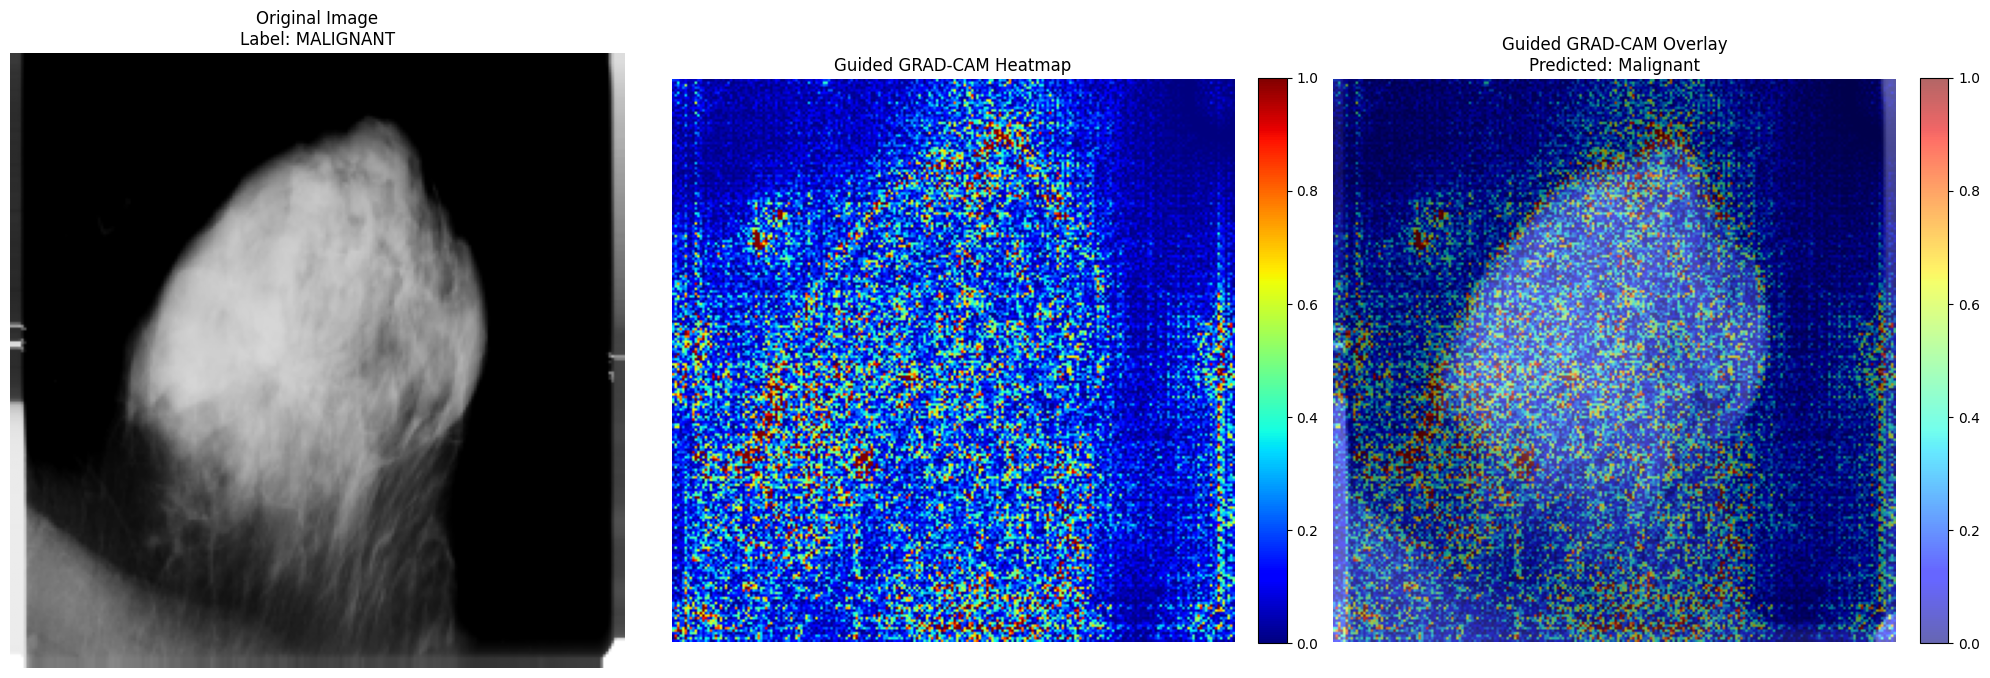

Guided GRAD-CAM Visualization
-----------------------------
Guided GRAD-CAM combines two visualization methods:
1. GRAD-CAM: Highlights regions important for the classification decision
2. Guided Backpropagation: Provides fine-grained feature importance

The combination gives us high-resolution visualization that is also class-discriminative.
This is particularly useful for medical imaging, where specific features may be very small
but critically important for diagnosis.


In [6]:
class GuidedBackprop:
    """
    Guided Backpropagation for visualization of gradients with respect to the input.
    This method modifies the backward pass to only pass positive gradients.
    Works with both CNN and Transformer architectures.
    """
    def __init__(self, model):
        self.model = model
        self.hooks = []
        self.gradients = None
        self.device = next(model.parameters()).device

        # Store for intermediate activations
        self.activation_maps = {}

        # Save original inplace states
        self.original_relu_states = {}

        # Disable inplace operations
        self._disable_inplace_relu()

        # Register hooks for ReLU and other activations
        self._register_hooks()

    def _disable_inplace_relu(self):
        """Disable inplace ReLU operations to avoid gradient issues."""
        for name, module in self.model.named_modules():
            if isinstance(module, nn.ReLU):
                # Save original state
                self.original_relu_states[name] = module.inplace
                # Disable inplace operation
                module.inplace = False

    def _restore_inplace_relu(self):
        """Restore original inplace ReLU settings."""
        for name, module in self.model.named_modules():
            if isinstance(module, nn.ReLU) and name in self.original_relu_states:
                module.inplace = self.original_relu_states[name]

    def _register_hooks(self):
        def forward_hook(module, input, output):
            # Store output in our dictionary
            module_id = id(module)
            # Handle tuple outputs by storing the first element
            if isinstance(output, tuple):
                self.activation_maps[module_id] = output[0].clone().detach()
            else:
                self.activation_maps[module_id] = output.clone().detach()

        def backward_hook(module, grad_in, grad_out):
            # Get the preactivation from our stored dictionary
            module_id = id(module)
            preact = self.activation_maps.get(module_id)

            if preact is not None:
                # Make sure to clone the gradients to avoid in-place issues
                grad_out_clone = grad_out[0].clone()

                # Only pass positive gradients for positive preactivations
                positive_grad_out = torch.clamp(grad_out_clone, min=0.0)
                positive_preact = (preact > 0).float()

                # Guided backpropagation: zero out gradients for negative preactivations
                guided_grad = positive_grad_out * positive_preact

                return (guided_grad,)
            else:
                return grad_in

        # Register hooks for all ReLU, GELU, and SiLU modules
        # (common in transformers, including Swin Transformer)
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.ReLU, nn.GELU, nn.SiLU)):
                # For the forward pass
                self.hooks.append(module.register_forward_hook(forward_hook))
                # For the backward pass
                self.hooks.append(module.register_full_backward_hook(backward_hook))

    def remove_hooks(self):
        """Remove all registered hooks, clear activation maps, and restore inplace operations."""
        for hook in self.hooks:
            hook.remove()
        self.activation_maps.clear()
        self._restore_inplace_relu()

    def generate_gradients(self, input_image, mask=None, target_class=None):
        """
        Generate guided backpropagation gradients

        Args:
            input_image: Input tensor (1, C, H, W)
            mask: Optional breast mask tensor (1, 1, H, W)
            target_class: Target class to visualize, if None uses predicted class

        Returns:
            gradients: Guided backpropagation gradients
            predicted_class: Predicted class
        """
        self.model.eval()

        # Clone input to ensure we don't modify the original
        input_image = input_image.clone().detach().to(self.device)
        input_image.requires_grad = True

        # Forward pass - don't use mask parameter to avoid issues
        try:
            output = self.model(input_image)

            # Get predicted class
            pred_class = output.argmax(dim=1).item()
            target_class = pred_class if target_class is None else target_class

            # One-hot encoding for the target class
            one_hot = torch.zeros_like(output)
            one_hot[0, target_class] = 1

            # Zero gradients
            self.model.zero_grad()

            # Backward pass
            output.backward(gradient=one_hot)

            # Get gradients
            if input_image.grad is None:
                print("Warning: No gradients were computed for the input image")
                return None, pred_class

            gradients = input_image.grad.clone().detach().cpu().numpy()[0]

            input_image.grad.data.zero_()

            return gradients, pred_class
        except Exception as e:
            print(f"Error in guided backprop: {str(e)}")
            import traceback
            traceback.print_exc()
            return None, None

def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    """
    Combine GRAD-CAM and Guided Backpropagation

    Args:
        grad_cam_mask: GRAD-CAM heatmap
        guided_backprop_mask: Guided backpropagation gradients

    Returns:
        guided_grad_cam: Combined visualization
    """
    # Ensure grad_cam_mask is 2D
    if len(grad_cam_mask.shape) > 2:
        grad_cam_mask = grad_cam_mask.squeeze()

    # Ensure guided_backprop_mask is 3D (C, H, W)
    if len(guided_backprop_mask.shape) == 2:
        guided_backprop_mask = guided_backprop_mask[np.newaxis, :, :]

    # Resize GRAD-CAM to match guided backprop if needed
    if grad_cam_mask.shape != guided_backprop_mask.shape[1:]:
        from scipy.ndimage import zoom
        # Calculate zoom factors for height and width
        h_factor = guided_backprop_mask.shape[1] / grad_cam_mask.shape[0]
        w_factor = guided_backprop_mask.shape[2] / grad_cam_mask.shape[1]
        # Resize using scipy's zoom
        grad_cam_mask = zoom(grad_cam_mask, [h_factor, w_factor], order=1)

    # Element-wise multiplication of guided backprop and GRAD-CAM
    guided_grad_cam = []
    for i in range(guided_backprop_mask.shape[0]):
        guided_grad_cam.append(guided_backprop_mask[i] * grad_cam_mask)

    guided_grad_cam = np.array(guided_grad_cam)

    return guided_grad_cam

def run_guided_grad_cam(model, image, mask, labels):
    """
    Wrapper function to run Guided GRAD-CAM with improved visualization
    Works with both CNN and Transformer architectures.

    Args:
        model: The model to explain
        image: Image tensor (1, C, H, W)
        mask: Mask tensor (1, 1, H, W)
        labels: Dictionary of labels

    Returns:
        fig: Matplotlib figure
        guided_gc: Guided GRAD-CAM visualization
    """
    # Get true label
    true_label = labels['pathology'][0]
    grad_cam_obj = None
    gbp_obj = None

    try:
        # Clone inputs to avoid issues
        image_copy = image.clone().detach()

        # Get GRAD-CAM first
        grad_cam_obj = GradCAM(model)
        cam, pred_class = grad_cam_obj.generate_cam(image_copy)

        # Get Guided Backpropagation
        gbp_obj = GuidedBackprop(model)
        guided_grads, gbp_pred_class = gbp_obj.generate_gradients(image_copy, target_class=pred_class)

        # Check if we got valid results
        if guided_grads is None:
            print("Failed to generate guided backpropagation gradients")
            if grad_cam_obj is not None:
                grad_cam_obj.remove_hooks()
            if gbp_obj is not None:
                gbp_obj.remove_hooks()
            return None, None

        # Combine to get Guided GRAD-CAM
        guided_gc = guided_grad_cam(cam, guided_grads)

        # Take absolute value for visualization
        if guided_gc.shape[0] > 0:  # Make sure we have at least one channel
            abs_guided_gc = np.abs(guided_gc[0])  # Use first channel
        else:
            print("Warning: Guided GRAD-CAM has no channels")
            abs_guided_gc = np.zeros_like(cam)

        # Apply contrast enhancement to better visualize the heatmap
        # Use percentile-based normalization to handle outliers
        p_low, p_high = np.percentile(abs_guided_gc, [2, 98])
        abs_guided_gc_norm = np.clip((abs_guided_gc - p_low) / (p_high - p_low + 1e-8), 0, 1)

        # Create visualization similar to GRAD-CAM format
        fig, axes = plt.subplots(1, 3, figsize=(20, 7))

        # Original image
        img_np = image_copy.squeeze().cpu().numpy()
        axes[0].imshow(img_np, cmap='gray')
        axes[0].set_title(f"Original Image\nLabel: {true_label}", fontsize=12)
        axes[0].axis('off')

        # Guided GRAD-CAM heatmap
        heatmap = axes[1].imshow(abs_guided_gc_norm, cmap='jet')
        axes[1].set_title("Guided GRAD-CAM Heatmap", fontsize=12)
        axes[1].axis('off')
        plt.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04)

        # Guided GRAD-CAM overlay
        axes[2].imshow(img_np, cmap='gray')
        overlay = axes[2].imshow(abs_guided_gc_norm, cmap='jet', alpha=0.6)
        axes[2].set_title(f"Guided GRAD-CAM Overlay\nPredicted: {'Malignant' if pred_class else 'Benign'}",
                        fontsize=12)
        axes[2].axis('off')
        plt.colorbar(overlay, ax=axes[2], fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()

        # Clean up
        if grad_cam_obj is not None:
            grad_cam_obj.remove_hooks()
        if gbp_obj is not None:
            gbp_obj.remove_hooks()

        return fig, guided_gc

    except Exception as e:
        print(f"Error generating Guided GRAD-CAM: {str(e)}")
        import traceback
        traceback.print_exc()

        if grad_cam_obj is not None:
            try:
                grad_cam_obj.remove_hooks()
            except:
                pass
        if gbp_obj is not None:
            try:
                gbp_obj.remove_hooks()
            except:
                pass

        return None, None

# Get a malignant sample for visualization
malignant_img, malignant_mask, malignant_labels = get_sample_by_pathology(test_loader, 'MALIGNANT')

# Run Guided GRAD-CAM
malignant_fig, malignant_guided_gc = run_guided_grad_cam(model, malignant_img, malignant_mask, malignant_labels)

print("Guided GRAD-CAM Visualization")
print("-----------------------------")
print("Guided GRAD-CAM combines two visualization methods:")
print("1. GRAD-CAM: Highlights regions important for the classification decision")
print("2. Guided Backpropagation: Provides fine-grained feature importance")
print()
print("The combination gives us high-resolution visualization that is also class-discriminative.")
print("This is particularly useful for medical imaging, where specific features may be very small")
print("but critically important for diagnosis.")

Successfully processed 30/30 samples
SmoothGrad: Removing Noise by Adding Noise
------------------------------------------
SmoothGrad improves gradient-based visualization by:
1. Adding random noise to the input image multiple times
2. Computing gradients for each noisy version
3. Averaging the gradients to produce a smoother attribution map

This technique reduces visual noise and artifacts in gradient visualizations,
making it easier to identify which regions of the mammogram are most important
for the model's classification decision.


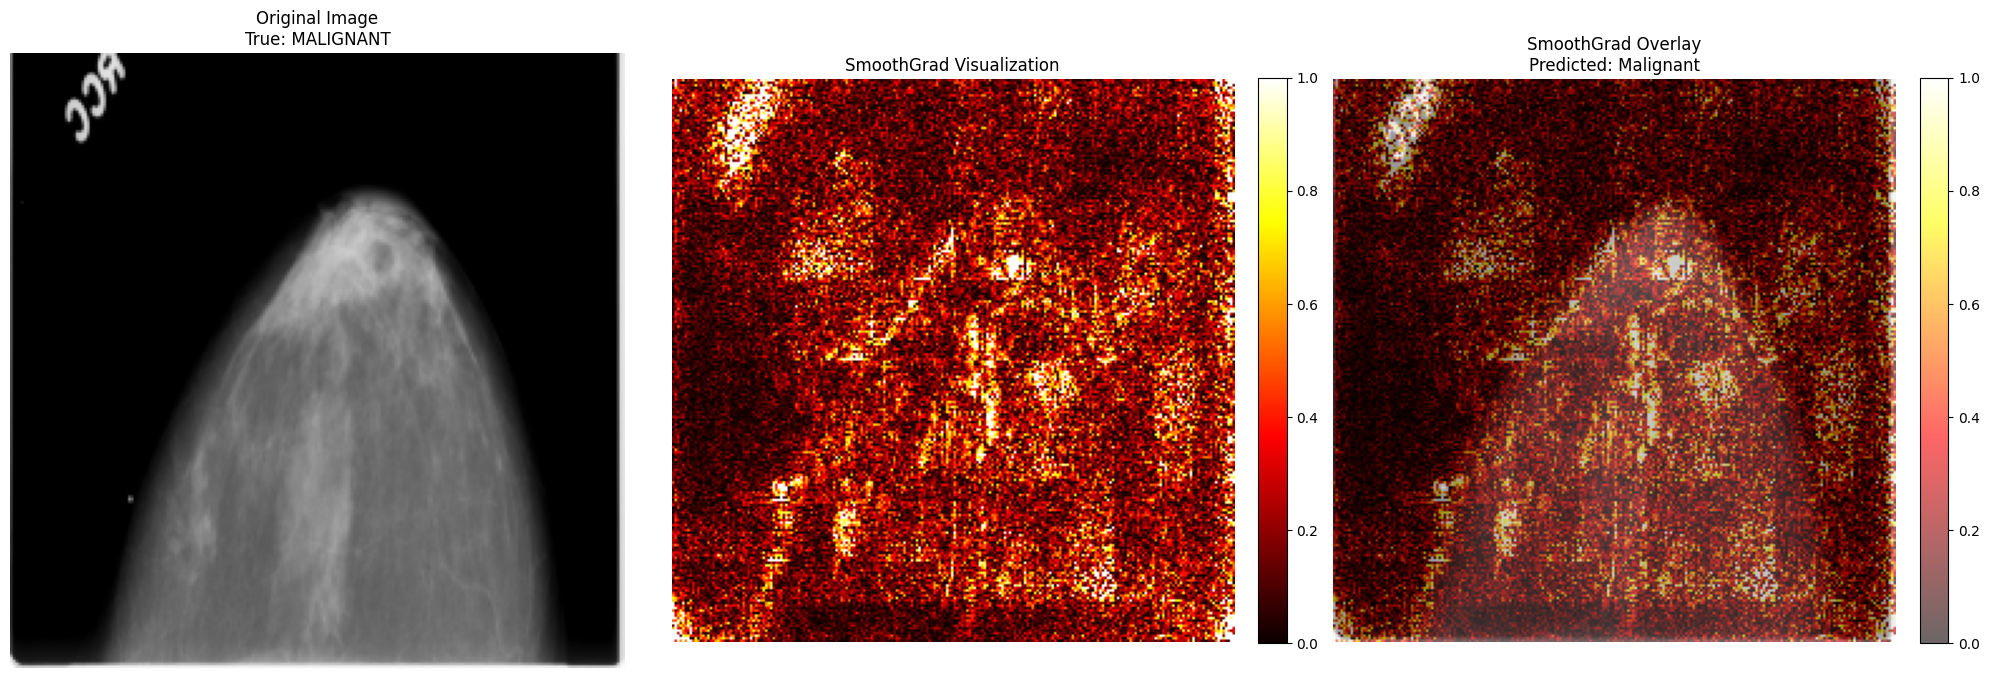

In [7]:
class SmoothGrad:
    """
    SmoothGrad: Removing noise by adding noise

    This method averages gradients from multiple noisy versions of the input
    to produce a smoother, more interpretable visualization.
    """
    def __init__(self, model, n_samples=50, noise_level=0.15):
        """
        Initialize SmoothGrad

        Args:
            model: PyTorch model
            n_samples: Number of noisy samples to average over
            noise_level: Standard deviation of the Gaussian noise as a fraction of input range
        """
        self.model = model
        self.n_samples = n_samples
        self.noise_level = noise_level
        self.device = next(model.parameters()).device

    def generate_gradients(self, input_image, target_class=None):
        """
        Generate vanilla gradients for the input image

        Args:
            input_image: Input tensor (1, C, H, W)
            target_class: Target class to visualize (if None, use predicted class)

        Returns:
            gradients: Gradients with respect to input
            predicted_class: Predicted class
        """
        self.model.eval()

        try:
            # Clone input to avoid modifying original
            input_image = input_image.clone().detach().to(self.device)
            input_image.requires_grad = True

            # Forward pass
            output = self.model(input_image)

            # Get predicted class
            pred_class = output.argmax(dim=1).item()
            target_class = pred_class if target_class is None else target_class

            # One-hot encoding for the target class
            one_hot = torch.zeros_like(output)
            one_hot[0, target_class] = 1

            # Zero gradients
            self.model.zero_grad()

            # Backward pass
            output.backward(gradient=one_hot)

            # Check if gradients were computed
            if input_image.grad is None:
                print("Warning: No gradients were computed for the input image")
                # Return zeros with the correct shape
                return torch.zeros_like(input_image), pred_class

            # Get gradients
            gradients = input_image.grad.data.clone()

            # Clean up
            input_image.grad.data.zero_()

            return gradients, pred_class

        except Exception as e:
            print(f"Error in generating gradients: {str(e)}")
            import traceback
            traceback.print_exc()
            # Return zeros with the correct shape in case of error
            return torch.zeros_like(input_image), -1

    def generate_smooth_grad(self, input_image, target_class=None):
        """
        Generate SmoothGrad visualization

        Args:
            input_image: Input tensor (1, C, H, W)
            target_class: Target class to visualize (if None, use predicted class)

        Returns:
            smooth_gradients: Averaged gradients from noisy samples
            predicted_class: Predicted class
        """
        self.model.eval()

        try:
            # Clone input for safe operations
            input_image = input_image.clone().detach().to(self.device)

            # Get predicted class if not specified
            if target_class is None:
                with torch.no_grad():
                    output = self.model(input_image)
                    target_class = output.argmax(dim=1).item()

            # Initialize smooth gradients
            smooth_gradients = torch.zeros_like(input_image).to(self.device)

            # Calculate standard deviation of the noise
            input_min = input_image.min().item()
            input_max = input_image.max().item()
            stdev = self.noise_level * (input_max - input_min)

            # Keep track of successful samples
            successful_samples = 0

            # Loop over noisy samples
            for i in range(self.n_samples):
                try:
                    # Add noise to the input image
                    noisy_image = input_image.clone().detach()
                    noise = torch.normal(0, stdev, size=input_image.shape, device=input_image.device)
                    noisy_image += noise

                    # Get gradients for this noisy sample
                    grad, _ = self.generate_gradients(noisy_image, target_class)

                    # Check if gradients are valid
                    if grad is not None and not torch.isnan(grad).any() and not torch.isinf(grad).any():
                        # Add to smooth gradients
                        smooth_gradients += grad
                        successful_samples += 1
                    else:
                        print(f"Sample {i+1}: Invalid gradients, skipping")

                except Exception as e:
                    print(f"Error in sample {i+1}: {str(e)}")
                    continue

            # Check if we have at least one successful sample
            if successful_samples == 0:
                print("Warning: No successful samples were generated")
                return smooth_gradients, target_class

            # Average gradients over successful samples
            smooth_gradients /= successful_samples
            print(f"Successfully processed {successful_samples}/{self.n_samples} samples")

            return smooth_gradients, target_class

        except Exception as e:
            print(f"Error in SmoothGrad: {str(e)}")
            import traceback
            traceback.print_exc()
            return torch.zeros_like(input_image), -1

    def visualize(self, image_tensor, smooth_grads, true_label, predicted_class):
        """
        Visualize the SmoothGrad results

        Args:
            image_tensor: Original input image
            smooth_grads: Smoothed gradients from SmoothGrad
            true_label: True label string
            predicted_class: Predicted class index

        Returns:
            fig: Matplotlib figure
        """
        try:
            # Process gradients for visualization
            # Take absolute value of gradients
            abs_grads = torch.abs(smooth_grads).cpu().numpy()

            # Ensure we have a shape of (C, H, W) or (H, W)
            if len(abs_grads.shape) == 4:  # (B, C, H, W)
                abs_grads = abs_grads[0]  # Take the first batch

            # If we have multiple channels, sum across channels for heatmap
            if len(abs_grads.shape) == 3:  # (C, H, W)
                # Sum across channels (better than just taking first channel)
                abs_grads = np.sum(abs_grads, axis=0)

            # Normalize for visualization using percentile-based scaling for robustness
            p_low, p_high = np.percentile(abs_grads, [2, 98])
            normalized_grads = np.clip((abs_grads - p_low) / (p_high - p_low + 1e-8), 0, 1)

            # Convert image tensor to numpy
            image_np = image_tensor.clone().detach().cpu().numpy()
            if len(image_np.shape) == 4:  # (B, C, H, W)
                image_np = image_np[0]  # Take first batch
            if len(image_np.shape) == 3:  # (C, H, W)
                image_np = image_np[0]  # Take first channel for grayscale display

            # Ensure we have a 2D array
            image_np = np.squeeze(image_np)

            # Check if dimensions match
            if image_np.shape != normalized_grads.shape:
                # Resize gradients to match image if needed
                from scipy.ndimage import zoom
                zoom_factors = (image_np.shape[0] / normalized_grads.shape[0],
                                image_np.shape[1] / normalized_grads.shape[1])
                normalized_grads = zoom(normalized_grads, zoom_factors, order=1)

            # Create figure with multiple visualizations
            fig, axes = plt.subplots(1, 3, figsize=(20, 7))

            # Original image
            axes[0].imshow(image_np, cmap='gray')
            axes[0].set_title(f"Original Image\nTrue: {true_label}", fontsize=12)
            axes[0].axis('off')

            # SmoothGrad
            sg_display = axes[1].imshow(normalized_grads, cmap='hot')
            axes[1].set_title("SmoothGrad Visualization", fontsize=12)
            axes[1].axis('off')
            plt.colorbar(sg_display, ax=axes[1], fraction=0.046, pad=0.04)

            # Overlay
            axes[2].imshow(image_np, cmap='gray')
            overlay = axes[2].imshow(normalized_grads, cmap='hot', alpha=0.6)
            axes[2].set_title(f"SmoothGrad Overlay\nPredicted: {'Malignant' if predicted_class == 1 else 'Benign'}",
                            fontsize=12)
            axes[2].axis('off')
            plt.colorbar(overlay, ax=axes[2], fraction=0.046, pad=0.04)

            plt.tight_layout()
            return fig

        except Exception as e:
            print(f"Error in visualization: {str(e)}")
            import traceback
            traceback.print_exc()
            # Create a simple error figure
            fig, ax = plt.subplots(1, 1, figsize=(10, 5))
            ax.text(0.5, 0.5, f"Visualization Error: {str(e)}",
                    horizontalalignment='center', verticalalignment='center')
            ax.axis('off')
            return fig

# Function to run SmoothGrad explanation
def run_smooth_grad(model, image, labels, n_samples=30, noise_level=0.10):
    """
    Run SmoothGrad explanation for a mammogram image

    Args:
        model: The model to explain
        image: Image tensor (1, C, H, W)
        labels: Dictionary of labels
        n_samples: Number of noisy samples (default lowered to 30 for faster processing)
        noise_level: Noise level as a fraction of the input range (default lowered to 0.10 for stability)

    Returns:
        fig: Matplotlib figure with the explanation
        smooth_grads: SmoothGrad gradients
    """
    # Get true label
    true_label = labels['pathology'][0]

    # Convert label to class index for target
    true_class = 1 if true_label.upper().startswith('MAL') else 0

    try:
        # Initialize SmoothGrad explainer
        smooth_grad_explainer = SmoothGrad(model, n_samples=n_samples, noise_level=noise_level)

        # Generate smoothed gradients
        smooth_grads, predicted_class = smooth_grad_explainer.generate_smooth_grad(image, target_class=true_class)

        # Check if generation succeeded
        if predicted_class == -1:
            print("Error occurred during SmoothGrad generation")
            return None, smooth_grads

        # Visualize results
        fig = smooth_grad_explainer.visualize(image, smooth_grads, true_label, predicted_class)

        return fig, smooth_grads

    except Exception as e:
        print(f"Error in run_smooth_grad: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None


malignant_image, malignant_mask, malignant_labels = get_sample_by_pathology(test_loader, 'MALIGNANT')

# Run SmoothGrad on the malignant sample - use fewer samples (30) for faster processing
fig_malignant, smooth_grads_malignant = run_smooth_grad(model, malignant_image, malignant_labels,
                                                      n_samples=30, noise_level=0.10)



print("SmoothGrad: Removing Noise by Adding Noise")
print("------------------------------------------")
print("SmoothGrad improves gradient-based visualization by:")
print("1. Adding random noise to the input image multiple times")
print("2. Computing gradients for each noisy version")
print("3. Averaging the gradients to produce a smoother attribution map")
print("\nThis technique reduces visual noise and artifacts in gradient visualizations,")
print("making it easier to identify which regions of the mammogram are most important")
print("for the model's classification decision.")

Transformer Attention Visualization
---------------------------------
This visualization shows where the transformer model is focusing its attention:
1. It extracts attention weights from the last attention block
2. Processes the weights to create an attention heatmap
3. Shows which regions of the mammogram are most attended to by the model

Attention maps provide insight into the transformer's decision-making process,
highlighting areas the model considers most relevant for classification.


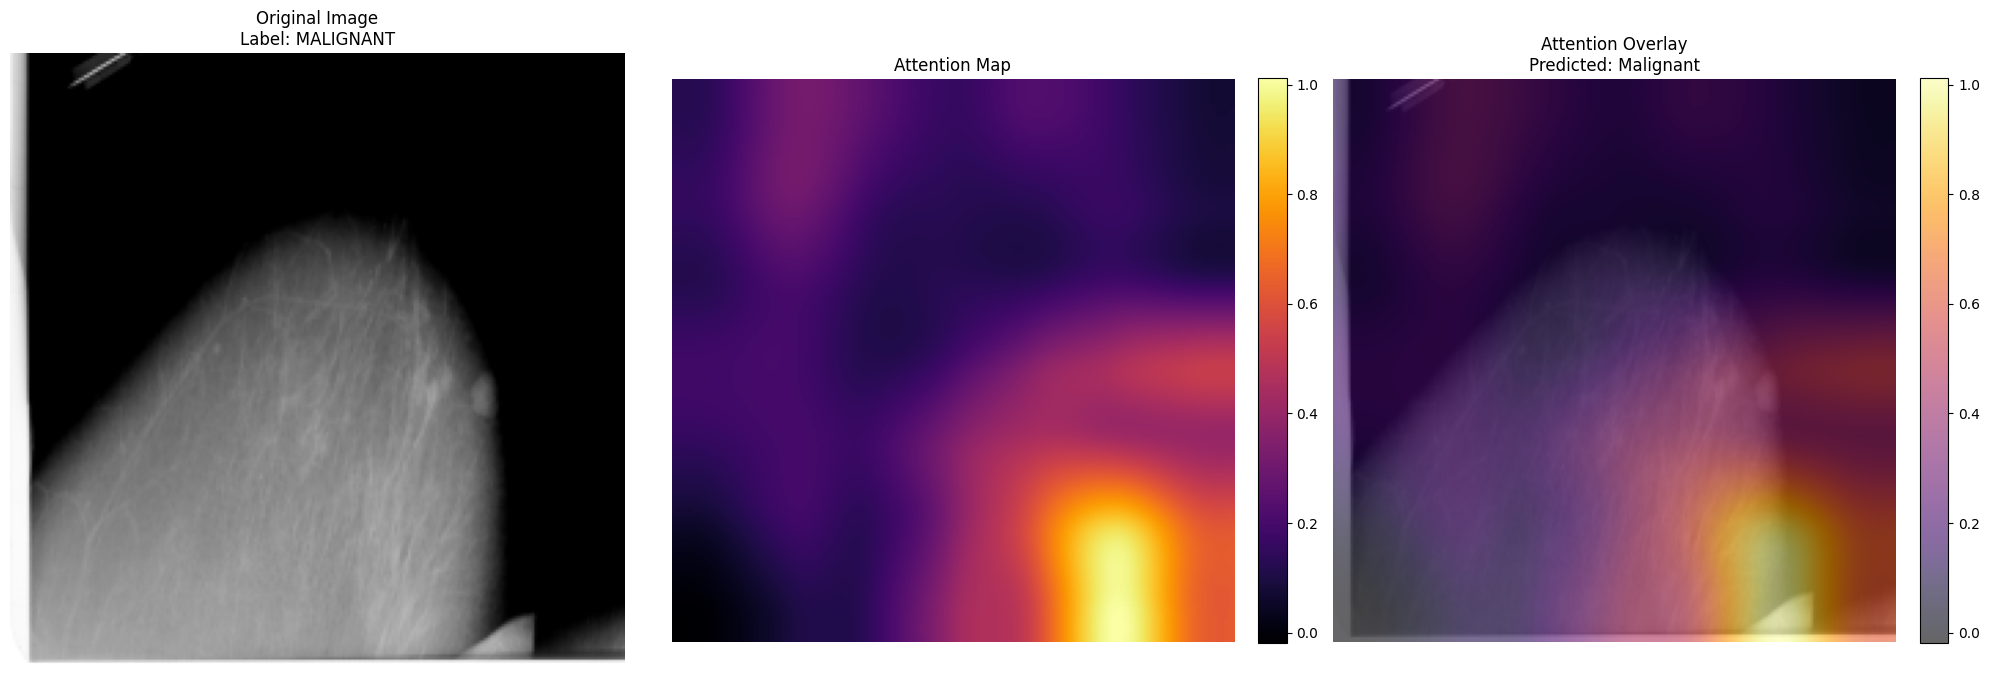

In [8]:
class AttentionVisualization:
    """
    Visualizes attention maps from transformer models for mammography images.

    This class extracts attention weights from transformer models like Swin Transformer
    and creates visualizations to help interpret where the model is focusing.
    """
    def __init__(self, model):
        """
        Initialize attention visualization

        Args:
            model: PyTorch transformer model
        """
        self.model = model
        self.device = next(model.parameters()).device
        self.attention_values = []

    def get_attention_block(self):
        """Find the appropriate attention block in the Swin Transformer model."""
        model = self.model

        # If model is wrapped, get the base model
        if hasattr(model, 'model'):
            model = model.model

        # Specifically for swin_base_patch4_window7_224 from timm
        if hasattr(model, 'layers') and len(model.layers) > 0:
            # Try to get the second-to-last stage for better interpretability
            # (last stage is often too abstract, while earlier stages focus on details)
            target_layer_idx = -3 if len(model.layers) > 1 else -1
            target_layer = model.layers[target_layer_idx]

            if hasattr(target_layer, 'blocks') and len(target_layer.blocks) > 0:
                # Get the last block in this stage
                last_block = target_layer.blocks[-1]

                # Check for attn attribute (standard in Swin Transformer)
                if hasattr(last_block, 'attn'):
                    return last_block.attn

        # Alternative search patterns for Swin Transformer

        # Method 1: Look specifically for WindowAttention modules
        window_attention_modules = []
        for name, module in model.named_modules():
            # Check module type name for window attention patterns
            module_type = type(module).__name__.lower()
            if 'window' in module_type and 'atten' in module_type:
                window_attention_modules.append((name, module))

        if window_attention_modules:
            # Use a window attention from a middle or late layer (not too early, not the very last)
            target_idx = len(window_attention_modules) // 2
            name, module = window_attention_modules[target_idx]
            return module

        # Method 2: Try to find any attention-like module
        attention_modules = []
        for name, module in model.named_modules():
            # Check for window attention by name
            if ('window' in name.lower() and 'atten' in name.lower()) or ('attn' in name.lower()):
                attention_modules.append((name, module))

        if attention_modules:
            name, module = attention_modules[-2] if len(attention_modules) > 1 else attention_modules[-1]
            return module

        # Method 3: Last-ditch effort - check for qkv projections
        for name, module in model.named_modules():
            if hasattr(module, 'qkv') or (hasattr(module, 'q') and hasattr(module, 'k') and hasattr(module, 'v')):
                return module

        # Fallback: if no attention module is found, use any significant layer
        for name, module in list(model.named_modules())[::-1]:  # Start from the end
            if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)) and not name.endswith('.weight'):
                return module

        print("Could not find any suitable attention or fallback layer")
        return None

    def process_attention_weights(self, attn_output, img_shape):
        """
        Process raw attention weights to create visualization map

        Args:
            attn_output: Attention output from the model
            img_shape: Shape of the original image

        Returns:
            attention_map: Processed attention map for visualization
        """
        try:
            # Convert to CPU and detach from computation graph
            attn = attn_output.detach().cpu()

            # Calculate feature magnitudes based on attention shape
            if len(attn.shape) == 4 and attn.shape[1] > 1:  # [batch, heads, seq_len, seq_len]
                # Average over attention heads
                attn = attn.mean(dim=1)

                # For self-attention, focus on the attention from CLS token or average across all tokens
                if attn.shape[1] == attn.shape[2]:  # Square attention matrix (seq_len × seq_len)
                    # Average over rows to get column-wise importance (how much each token is attended to)
                    feature_magnitudes = attn.mean(dim=1)
                else:
                    # Non-square case - use the first dimension
                    feature_magnitudes = attn.mean(dim=2)

            elif len(attn.shape) == 3:  # [batch, seq_len, dim] or [batch, seq_len, seq_len]
                # If last dimension equals seq_len, it might be attention scores
                if attn.shape[1] == attn.shape[2]:
                    # Likely attention scores - average over the first dimension
                    feature_magnitudes = attn[0].mean(dim=0)
                else:
                    # Feature vectors - calculate magnitude of each vector
                    feature_magnitudes = torch.norm(attn[0], dim=-1)

            elif len(attn.shape) == 2:  # [seq_len, dim] or similar
                # Calculate magnitude of feature vectors
                feature_magnitudes = torch.norm(attn, dim=-1)

            else:
                # Fallback approach
                # Flatten all dimensions except the first
                reshaped = attn.reshape(attn.shape[0], -1)
                # Take magnitude across the flattened dimension
                feature_magnitudes = torch.norm(reshaped, dim=1)

            # Normalize to 0-1 range
            if feature_magnitudes.max() == feature_magnitudes.min():
                attention_map = torch.ones_like(feature_magnitudes)
            else:
                attention_map = (feature_magnitudes - feature_magnitudes.min()) / \
                               (feature_magnitudes.max() - feature_magnitudes.min() + 1e-8)

            # Convert to numpy for processing
            attention_map = attention_map.numpy()

            # For Swin Transformer's window-based attention, we need to reconstruct the spatial attention map
            # Reshape if needed - for sequence data, try to make it 2D
            if len(attention_map.shape) == 1:
                seq_len = attention_map.shape[0]

                # Try to find the best square or rectangle shape
                possible_sizes = []
                for h in range(1, seq_len + 1):
                    if seq_len % h == 0:
                        w = seq_len // h
                        possible_sizes.append((h, w, abs(h - w)))  # height, width, difference

                # Find the shape closest to a square
                if possible_sizes:
                    best_shape = min(possible_sizes, key=lambda x: x[2])
                    h, w = best_shape[0], best_shape[1]
                    attention_map = attention_map.reshape(h, w)
                else:
                    # Perfect square case
                    size = int(np.sqrt(seq_len))
                    if size * size == seq_len:
                        attention_map = attention_map.reshape(size, size)
                    else:
                        # Create a dummy 2D map
                        attention_map = np.ones((32, 32))

            # Resize to match input image dimensions using pytorch
            try:
                attention_map = F.interpolate(
                    torch.from_numpy(attention_map).unsqueeze(0).unsqueeze(0).float(),
                    size=img_shape[-2:],
                    mode='bicubic',
                    align_corners=False
                ).squeeze().numpy()
            except Exception as resize_error:
                print(f"Error during resize: {resize_error}")
                from scipy.ndimage import zoom

                # Calculate zoom factors
                h_factor = img_shape[-2] / attention_map.shape[0]
                w_factor = img_shape[-1] / attention_map.shape[1]

                # Resize using scipy zoom
                attention_map = zoom(attention_map, (h_factor, w_factor), order=1)

            return attention_map

        except Exception as e:
            print(f"Error processing attention weights: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

    def visualize(self, image, labels):
        """
        Generate and visualize attention maps

        Args:
            image: Input image tensor (1, C, H, W)
            labels: Dictionary of labels

        Returns:
            fig: Matplotlib figure
            attention_map: Processed attention map
        """
        try:
            # Get true label
            true_label = labels['pathology'][0]

            # Find appropriate attention block
            attn_block = self.get_attention_block()
            if attn_block is None:
                # Fallback: capture activations from last layer with significant size
                activations = []

                # Find a suitable convolutional or feature layer
                target_module = None
                for name, module in list(self.model.named_modules())[::-1]:
                    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
                        target_module = module
                        break

                if target_module is None:
                    print("Could not find any suitable layer for visualization")
                    return None, None

                # Register hook on the fallback layer
                def activation_hook(module, input, output):
                    activations.append(output)

                handle = target_module.register_forward_hook(activation_hook)

                # Run model inference
                self.model.eval()
                with torch.no_grad():
                    outputs = self.model(image)
                    pred_class = outputs.argmax(dim=1).item()

                # Remove hook
                handle.remove()

                # Check if activations were captured
                if not activations:
                    print("No activations captured")
                    return None, None

                # Use activation as a heatmap
                feature_map = activations[0]

                # Average across channels if needed
                if len(feature_map.shape) > 2:
                    if feature_map.shape[1] > 1:  # Multiple channels
                        feature_map = torch.mean(feature_map, dim=1, keepdim=True)

                # Create a heatmap from feature magnitudes
                feature_magnitude = torch.abs(feature_map)
                heatmap = feature_magnitude / (feature_magnitude.max() + 1e-8)

                # Resize to match input image
                try:
                    heatmap_resized = F.interpolate(
                        heatmap,
                        size=(image.shape[2], image.shape[3]),
                        mode='bicubic',
                        align_corners=False
                    ).squeeze().cpu().numpy()
                except Exception as resize_error:
                    print(f"Error during feature resize: {resize_error}")
                    # Fallback: create a dummy heatmap
                    heatmap_resized = np.ones((image.shape[2], image.shape[3]))

                # Create visualization with the feature map heatmap
                fig, axes = plt.subplots(1, 3, figsize=(20, 7))

                # Original image
                img_np = image.squeeze().cpu().numpy()
                img_np = np.squeeze(img_np)

                axes[0].imshow(img_np, cmap='gray')
                axes[0].set_title(f"Original Image\nLabel: {true_label}", fontsize=12)
                axes[0].axis('off')

                # Feature map
                feature_display = axes[1].imshow(heatmap_resized, cmap='inferno')
                axes[1].set_title("Feature Activation Map", fontsize=12)
                axes[1].axis('off')
                plt.colorbar(feature_display, ax=axes[1], fraction=0.046, pad=0.04)

                # Overlay
                axes[2].imshow(img_np, cmap='gray')
                overlay = axes[2].imshow(heatmap_resized, cmap='inferno', alpha=0.6)
                axes[2].set_title(f"Feature Map Overlay\nPredicted: {'Malignant' if pred_class == 1 else 'Benign'}",
                                fontsize=12)
                axes[2].axis('off')
                plt.colorbar(overlay, ax=axes[2], fraction=0.046, pad=0.04)

                plt.tight_layout()

                return fig, heatmap_resized

            # Reset attention values list
            self.attention_values = []

            # Register forward hook to capture attention output
            def hook_fn(module, input, output):
                # For Window Attention in Swin Transformer
                if isinstance(output, tuple):
                    # Some attention modules return (attention, value) or similar
                    # Try to find the attention matrix - typically first or last element
                    attn_matrix = None
                    for i, out in enumerate(output):
                        if hasattr(out, 'shape'):
                            # Typically, attention matrix has 'heads' dimension
                            if len(out.shape) >= 3:
                                attn_matrix = out
                                break

                    if attn_matrix is not None:
                        self.attention_values.append(attn_matrix)
                    else:
                        # Default to first output
                        self.attention_values.append(output[0])
                else:
                    # Simple case - just one output
                    self.attention_values.append(output)

            handle = attn_block.register_forward_hook(hook_fn)

            # Run model inference
            self.model.eval()
            with torch.no_grad():
                outputs = self.model(image)
                pred_class = outputs.argmax(dim=1).item()

            # Remove hook
            handle.remove()

            # Check if attention values were captured
            if not self.attention_values:
                print("No attention values captured")
                return None, None

            # Process attention weights
            attention_map = self.process_attention_weights(self.attention_values[0], image.shape)
            if attention_map is None:
                print("Could not process attention weights")
                return None, None

            # Apply Gaussian blur for smoother visualization (optional)
            from scipy.ndimage import gaussian_filter
            attention_map = gaussian_filter(attention_map, sigma=1.0)

            # Create visualization
            fig, axes = plt.subplots(1, 3, figsize=(20, 7))

            # Original image
            img_np = image.squeeze().cpu().numpy()
            # Ensure we have a 2D array
            img_np = np.squeeze(img_np)

            axes[0].imshow(img_np, cmap='gray')
            axes[0].set_title(f"Original Image\nLabel: {true_label}", fontsize=12)
            axes[0].axis('off')

            # Attention map
            attention_display = axes[1].imshow(attention_map, cmap='inferno')
            axes[1].set_title("Attention Map", fontsize=12)
            axes[1].axis('off')
            plt.colorbar(attention_display, ax=axes[1], fraction=0.046, pad=0.04)

            # Overlay
            axes[2].imshow(img_np, cmap='gray')
            overlay = axes[2].imshow(attention_map, cmap='inferno', alpha=0.6)
            axes[2].set_title(f"Attention Overlay\nPredicted: {'Malignant' if pred_class == 1 else 'Benign'}",
                            fontsize=12)
            axes[2].axis('off')
            plt.colorbar(overlay, ax=axes[2], fraction=0.046, pad=0.04)

            plt.tight_layout()

            return fig, attention_map

        except Exception as e:
            print(f"Error in attention visualization: {str(e)}")
            import traceback
            traceback.print_exc()
            return None, None

# Function to run attention visualization
def run_attention_visualization(model, image, labels):
    """
    Run attention visualization for a mammogram image

    Args:
        model: The model to explain
        image: Image tensor (1, C, H, W)
        labels: Dictionary of labels

    Returns:
        fig: Matplotlib figure with the explanation
        attention_map: Attention map
    """
    try:
        # Initialize attention visualization explainer
        attn_viz = AttentionVisualization(model)

        # Generate and visualize attention maps
        fig, attention_map = attn_viz.visualize(image, labels)

        if fig is None:
            print("Attention visualization failed to produce a figure")

        return fig, attention_map

    except Exception as e:
        print(f"Error in run_attention_visualization: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

# Get samples for visualization
malignant_image, malignant_mask, malignant_labels = get_sample_by_pathology(test_loader, 'MALIGNANT')

# Run attention visualization on the malignant sample
fig_malignant, attn_map_malignant = run_attention_visualization(model, malignant_image, malignant_labels)

print("Transformer Attention Visualization")
print("---------------------------------")
print("This visualization shows where the transformer model is focusing its attention:")
print("1. It extracts attention weights from the last attention block")
print("2. Processes the weights to create an attention heatmap")
print("3. Shows which regions of the mammogram are most attended to by the model")
print("\nAttention maps provide insight into the transformer's decision-making process,")
print("highlighting areas the model considers most relevant for classification.")

Generating adversarial example for malignant sample...
WRM (Wasserstein Risk Minimization) for Adversarial Examples
------------------------------------------------------------
WRM generates adversarial examples that can fool the model by:
1. Iteratively optimizing perturbations to maximize the loss
2. Using L2 regularization to keep adversarial examples visually similar to originals

Adversarial examples help us understand:
- How robust the model is to small perturbations
- Which regions in the image contribute most to the classification decision
- Potential vulnerabilities in the model's decision-making process

In medical imaging, this is particularly important as it can reveal:
- How to improve model robustness through adversarial training


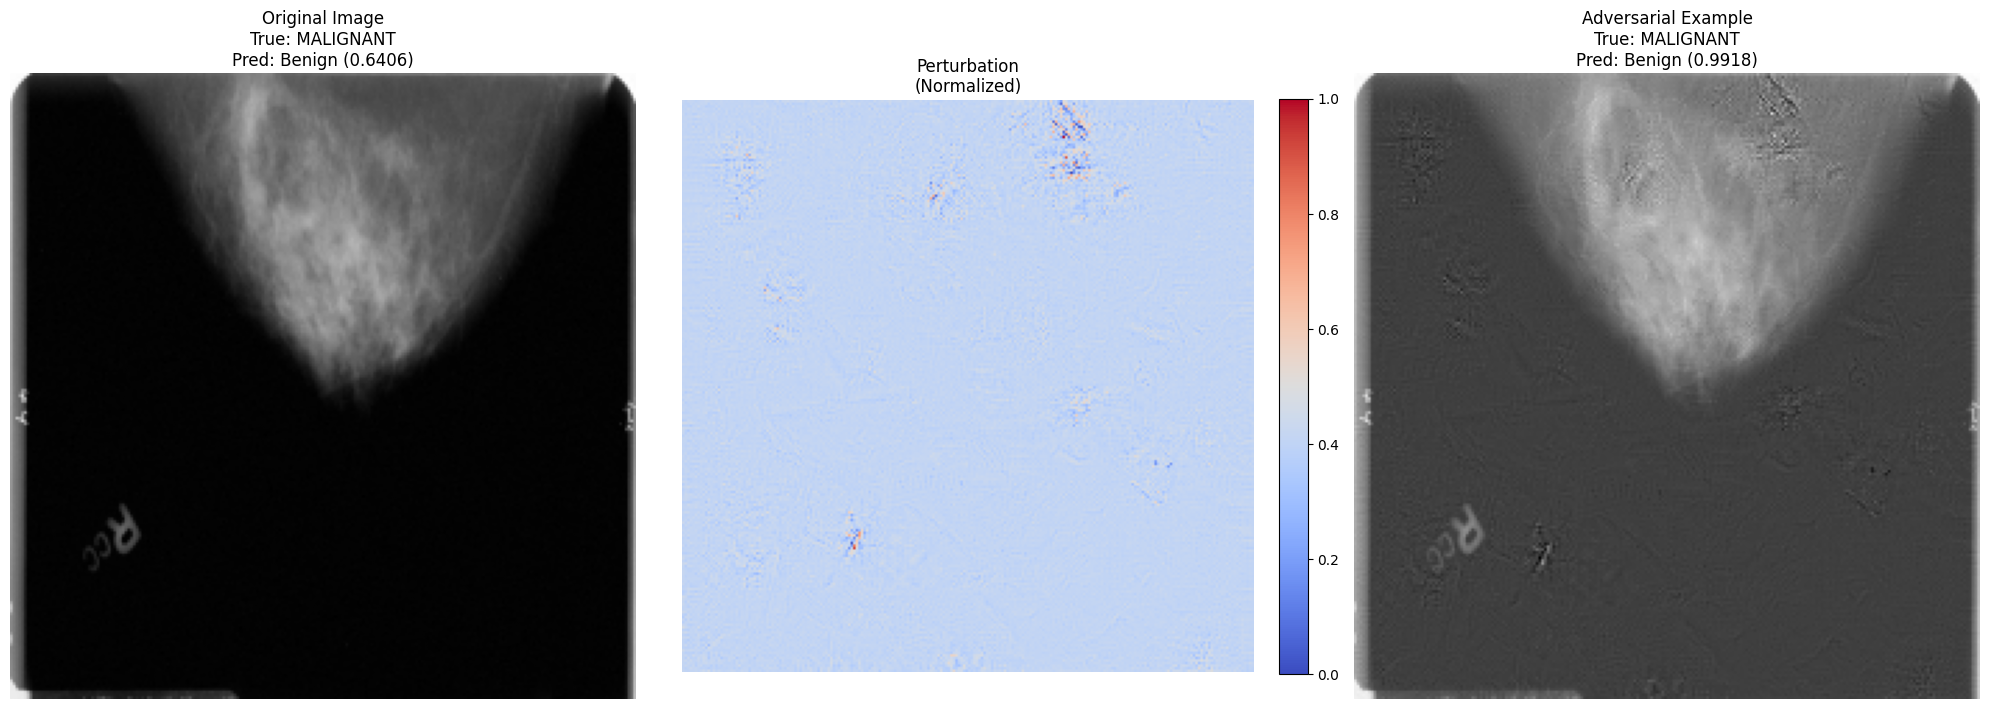

In [9]:
class WRMLoss(nn.Module):
    """
    Wasserstein Risk Minimization for generating adversarial examples
    """
    def __init__(self, eps=0.3, steps=15):
        """
        Initialize WRM Loss

        Args:
            eps: Epsilon for controlling perturbation size
            steps: Number of optimization steps
        """
        super().__init__()
        self.eps = eps
        self.steps = steps

    def forward(self, model, images, masks, labels, criterion):
        """
        Forward pass to generate adversarial examples using WRM

        Args:
            model: The model to attack
            images: Input images
            masks: Breast masks
            labels: Target labels
            criterion: Loss function (e.g., CrossEntropyLoss)

        Returns:
            final_loss: Loss on the adversarial examples
            x_adv: Generated adversarial examples
        """
        # Clone the input images and move to GPU
        x_adv = images.detach().clone()
        x_adv.requires_grad_(True)

        # Initial prediction and gradient computation
        outputs = model(x_adv)
        loss = criterion(outputs, labels)
        grad = torch.autograd.grad(self.eps * loss, x_adv, create_graph=True)[0]

        # If we have masks, only apply perturbation within the breast area
        if masks is not None:
            grad = grad * masks

        x_adv = x_adv + grad.detach()

        # Iterative optimization
        for t in range(self.steps):
            x_adv = x_adv.detach().clone()
            x_adv.requires_grad_(True)

            # Forward pass and loss computation
            outputs = model(x_adv)
            loss = criterion(outputs, labels)
            grad = torch.autograd.grad(self.eps * loss, x_adv, create_graph=True)[0]

            # L2 regularization to keep adversarial example close to original
            l2_loss = 0.5 * torch.sum((x_adv - images) ** 2)
            grad_reg = torch.autograd.grad(l2_loss, x_adv, create_graph=True)[0]

            # Combine gradients and update adversarial example
            grad = grad - grad_reg

            # If we have masks, only apply perturbation within the breast area
            # if masks is not None:
            #     grad = grad * masks

            step_size = 1.0 / torch.sqrt(torch.tensor(t + 2.0, device=x_adv.device, dtype=torch.float))
            x_adv = x_adv + step_size * grad.detach()

        # Final forward pass to get loss on adversarial examples
        final_outputs = model(x_adv.detach())
        final_loss = criterion(final_outputs, labels)

        return final_loss, x_adv.detach()


# Function to generate adversarial examples using WRM
def generate_adversarial_example(model, image, mask, labels, eps=0.3, steps=15):
    """
    Generate adversarial example using WRM

    Args:
        model: The model to attack
        image: Input image tensor (1, C, H, W)
        mask: Breast mask tensor (1, 1, H, W)
        labels: Dictionary of labels
        eps: Epsilon for controlling perturbation size
        steps: Number of optimization steps

    Returns:
        adv_image: Generated adversarial example
        orig_pred: Original prediction
        adv_pred: Prediction on adversarial example
    """
    model.eval()

    # Convert string pathology to numeric label
    numeric_label = convert_pathology_to_label(labels['pathology'])

    # Initialize WRM loss
    wrm_loss = WRMLoss(eps=eps, steps=steps)
    criterion = nn.CrossEntropyLoss()

    # Get original prediction
    with torch.no_grad():
        output = model(image)
        orig_pred = output.argmax(dim=1).item()
        orig_prob = F.softmax(output, dim=1)[0, orig_pred].item()

    # Generate adversarial example
    _, adv_image = wrm_loss(model, image, mask, numeric_label, criterion)

    # Get prediction on adversarial example
    with torch.no_grad():
        adv_output = model(adv_image)
        adv_pred = adv_output.argmax(dim=1).item()
        adv_prob = F.softmax(adv_output, dim=1)[0, adv_pred].item()

    return adv_image, orig_pred, orig_prob, adv_pred, adv_prob

# Function to visualize the adversarial example
def visualize_adversarial_example(image, mask, adv_image, labels, orig_pred, orig_prob, adv_pred, adv_prob):
    """
    Visualize the original and adversarial examples in a 1x3 grid

    Args:
        image: Original image tensor
        mask: Breast mask tensor
        adv_image: Adversarial image tensor
        labels: Dictionary of labels
        orig_pred: Original prediction
        orig_prob: Original prediction probability
        adv_pred: Adversarial prediction
        adv_prob: Adversarial prediction probability

    Returns:
        fig: Matplotlib figure
    """
    # Convert tensors to numpy arrays
    orig_img = image.squeeze().cpu().numpy()
    adv_img = adv_image.squeeze().cpu().numpy()

    # Calculate difference
    diff = adv_img - orig_img
    diff_normalized = (diff - diff.min()) / (diff.max() - diff.min() + 1e-8)

    # Get true label
    true_label = labels['pathology'][0]

    # Create visualization with 1x3 grid
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    # Original image
    axes[0].imshow(orig_img, cmap='gray')
    axes[0].set_title(f"Original Image\nTrue: {true_label}\nPred: {'Malignant' if orig_pred == 1 else 'Benign'} ({orig_prob:.4f})")
    axes[0].axis('off')

    # Perturbation
    im = axes[1].imshow(diff_normalized, cmap='coolwarm')
    axes[1].set_title("Perturbation\n(Normalized)")
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # Adversarial image
    axes[2].imshow(adv_img, cmap='gray')
    axes[2].set_title(f"Adversarial Example\nTrue: {true_label}\nPred: {'Malignant' if adv_pred == 1 else 'Benign'} ({adv_prob:.4f})")
    axes[2].axis('off')

    plt.tight_layout()

    return fig

# Run WRM to generate and visualize adversarial examples
def run_wrm_adversarial(model, image, mask, labels, eps=0.3, steps=15):
    """
    Wrapper function to generate and visualize adversarial examples

    Args:
        model: The model to attack
        image: Input image tensor (1, C, H, W)
        mask: Mask tensor (1, 1, H, W)
        labels: Dictionary of labels
        eps: Epsilon for controlling perturbation size
        steps: Number of optimization steps

    Returns:
        fig: Matplotlib figure
        adv_image: Generated adversarial example
    """
    # Generate adversarial example
    adv_image, orig_pred, orig_prob, adv_pred, adv_prob = generate_adversarial_example(
        model, image, mask, labels, eps, steps
    )

    # Visualize
    fig = visualize_adversarial_example(
        image, mask, adv_image, labels, orig_pred, orig_prob, adv_pred, adv_prob
    )

    return fig, adv_image

# Get samples for adversarial example generation
malignant_image, malignant_mask, malignant_labels = get_sample_by_pathology(test_loader, 'MALIGNANT')


# Run adversarial example generation on malignant sample
print("Generating adversarial example for malignant sample...")
fig_malignant, adv_malignant = run_wrm_adversarial(
    model, malignant_image, malignant_mask, malignant_labels, eps=0.3, steps=15
)


print("WRM (Wasserstein Risk Minimization) for Adversarial Examples")
print("------------------------------------------------------------")
print("WRM generates adversarial examples that can fool the model by:")
print("1. Iteratively optimizing perturbations to maximize the loss")
print("2. Using L2 regularization to keep adversarial examples visually similar to originals")
print()
print("Adversarial examples help us understand:")
print("- How robust the model is to small perturbations")
print("- Which regions in the image contribute most to the classification decision")
print("- Potential vulnerabilities in the model's decision-making process")
print()
print("In medical imaging, this is particularly important as it can reveal:")
print("- How to improve model robustness through adversarial training")

Generating targeted adversarial example: malignant → benign...
Targeted WRM (Wasserstein Risk Minimization) for Adversarial Examples
---------------------------------------------------------------------
Targeted WRM generates adversarial examples that fool the model into making a specific prediction:
1. Iteratively optimizing perturbations to maximize the likelihood of the target class
2. Using L2 regularization to keep adversarial examples visually similar to originals

These examples reveal:
- Decision boundaries between benign and malignant classifications
- Features that can change a diagnosis from benign to malignant and vice versa
- How minimal changes to the image can lead to completely different predictions


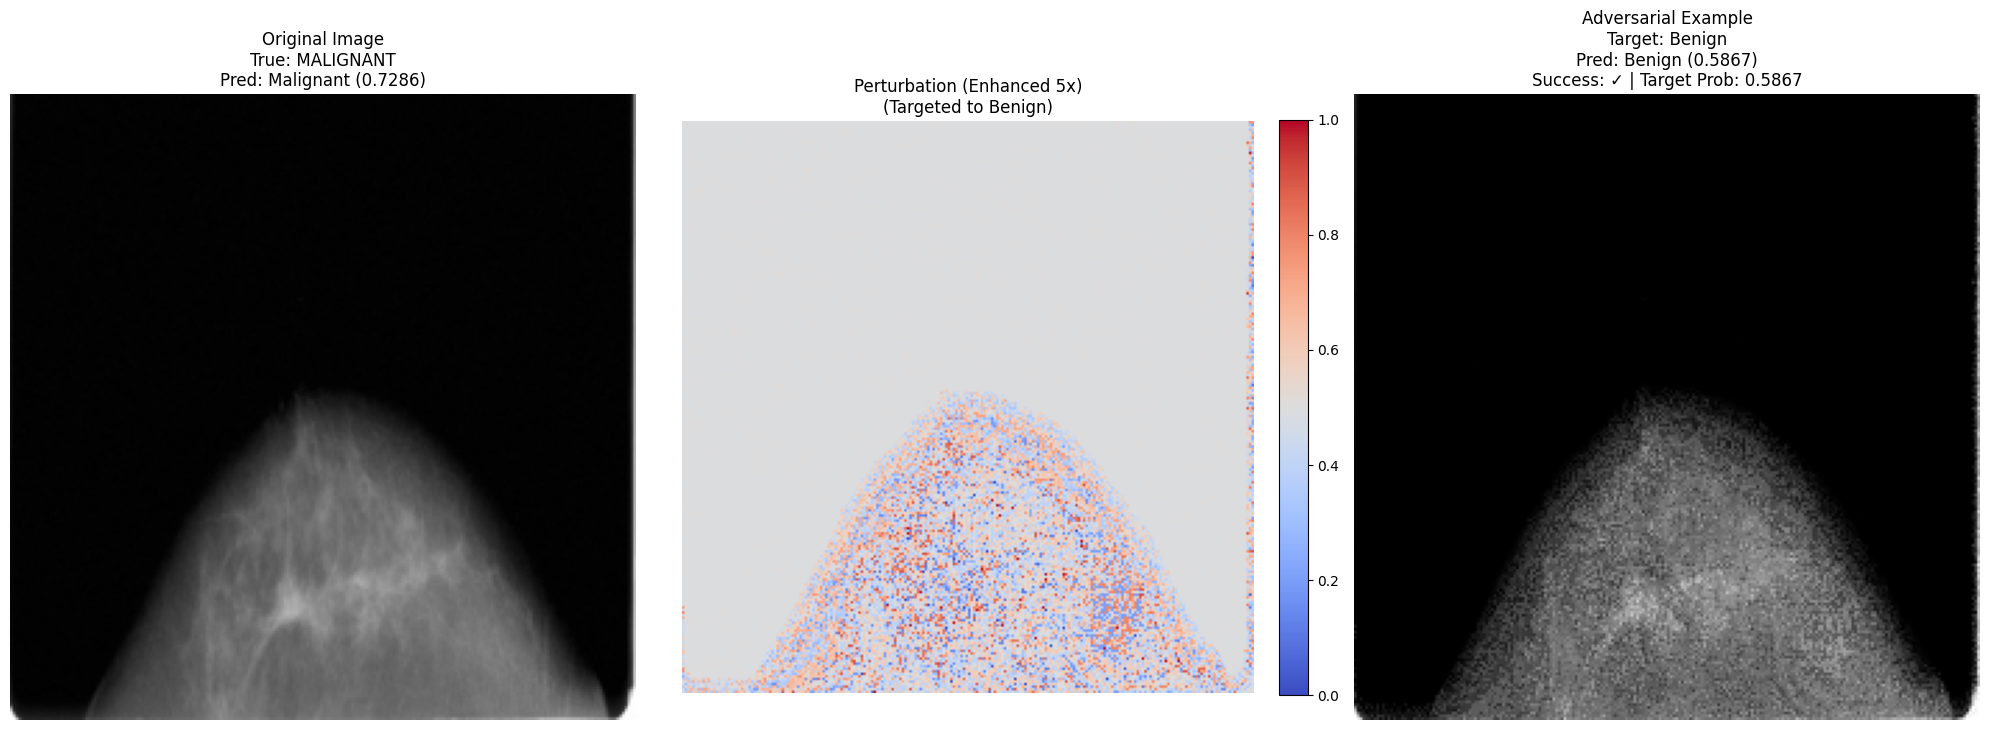

In [10]:
class TargetedWRMLoss(nn.Module):
    """
    Targeted Wasserstein Risk Minimization for generating adversarial examples
    that are classified as a specific target class
    """
    def __init__(self, eps=0.5, steps=30, alpha=2.0):
        """
        Initialize Targeted WRM Loss

        Args:
            eps: Epsilon for controlling perturbation size (increased from 0.3 to 0.5)
            steps: Number of optimization steps (increased from 15 to 30)
            alpha: Weight factor for the probability margin loss (new parameter)
        """
        super().__init__()
        self.eps = eps
        self.steps = steps
        self.alpha = alpha

    def forward(self, model, images, masks, target_labels, criterion):
        """
        Forward pass to generate targeted adversarial examples using WRM

        Args:
            model: The model to attack
            images: Input images
            masks: Breast masks
            target_labels: Target labels (the class we want the model to predict)
            criterion: Loss function (not used in this implementation, kept for compatibility)

        Returns:
            final_loss: Loss on the adversarial examples
            x_adv: Generated adversarial examples
        """
        # Clone the input images and move to GPU
        x_adv = images.detach().clone()

        # Get predicted class from original image
        with torch.no_grad():
            outputs = model(images)
            orig_class = outputs.argmax(dim=1)

        # Get target class
        target_class = target_labels.item()

        # Initialize momentum for faster convergence
        momentum = torch.zeros_like(x_adv)

        # For targeted attacks, we want to minimize the margin between
        # target class probability and original class probability
        for t in range(self.steps):
            x_adv = x_adv.detach().clone()
            x_adv.requires_grad_(True)

            # Forward pass and probability computation
            outputs = model(x_adv)
            probs = F.softmax(outputs, dim=1)

            # Calculate probability margin - we want to minimize this
            margin_loss = probs[0, orig_class] - probs[0, target_class]

            # L2 regularization to keep adversarial example close to original
            l2_loss = 0.5 * torch.sum((x_adv - images) ** 2)

            # Combined loss (we want to minimize this)
            combined_loss = self.alpha * margin_loss + l2_loss

            # Calculate gradients
            grad = torch.autograd.grad(combined_loss, x_adv)[0]

            # If we have masks, only apply perturbation within the breast area
            if masks is not None:
                grad = grad * masks

            # Apply momentum for more stable updates
            momentum = 0.9 * momentum + grad / (torch.norm(grad, p=1) + 1e-8)

            # Adaptive step size that decreases over iterations
            step_size = self.eps * (1.0 - t/self.steps)

            # Update adversarial example
            x_adv = x_adv - step_size * torch.sign(momentum)

            # Clip to ensure the adversarial example stays within valid range
            x_adv = torch.clamp(x_adv, 0.0, 1.0)

            # Project back to valid perturbation range
            delta = x_adv - images
            delta = torch.clamp(delta, -self.eps, self.eps)
            x_adv = images + delta

        # Final forward pass to get loss on adversarial examples
        final_outputs = model(x_adv.detach())
        final_probs = F.softmax(final_outputs, dim=1)
        final_loss = -torch.log(final_probs[0, target_class])

        return final_loss, x_adv.detach()


# Function to generate targeted adversarial examples using WRM
def generate_targeted_adversarial_example(model, image, mask, labels, target_class, eps=0.5, steps=30):
    """
    Generate targeted adversarial example using WRM

    Args:
        model: The model to attack
        image: Input image tensor (1, C, H, W)
        mask: Breast mask tensor (1, 1, H, W)
        labels: Dictionary of labels
        target_class: Target class index (the class we want the model to predict)
        eps: Epsilon for controlling perturbation size (increased from 0.3 to 0.5)
        steps: Number of optimization steps (increased from 15 to 30)

    Returns:
        adv_image: Generated adversarial example
        orig_pred: Original prediction
        orig_prob: Original prediction probability
        adv_pred: Prediction on adversarial example
        adv_prob: Adversarial prediction probability
        target_prob: Probability of target class in adversarial example
    """
    model.eval()

    # Convert string pathology to numeric label
    numeric_label = convert_pathology_to_label(labels['pathology'])

    # Create target label (the specified target class)
    target_label = torch.tensor([target_class], dtype=torch.long).to(device)

    # Initialize targeted WRM loss with default alpha=2.0
    targeted_wrm_loss = TargetedWRMLoss(eps=eps, steps=steps)
    criterion = nn.CrossEntropyLoss()  # Not used in the new implementation, but kept for compatibility

    # Get original prediction
    with torch.no_grad():
        output = model(image)
        orig_pred = output.argmax(dim=1).item()
        orig_prob = F.softmax(output, dim=1)[0, orig_pred].item()

    # Generate adversarial example
    _, adv_image = targeted_wrm_loss(model, image, mask, target_label, criterion)

    # Get prediction on adversarial example
    with torch.no_grad():
        adv_output = model(adv_image)
        adv_pred = adv_output.argmax(dim=1).item()
        adv_prob = F.softmax(adv_output, dim=1)[0, adv_pred].item()
        target_prob = F.softmax(adv_output, dim=1)[0, target_class].item()

    return adv_image, orig_pred, orig_prob, adv_pred, adv_prob, target_prob

# Function to visualize the adversarial example
def visualize_adversarial_example(image, mask, adv_image, labels, orig_pred, orig_prob, adv_pred, adv_prob, target_class, target_prob=None):
    """
    Visualize the original and adversarial examples in a 1x3 grid

    Args:
        image: Original image tensor
        mask: Breast mask tensor
        adv_image: Adversarial image tensor
        labels: Dictionary of labels
        orig_pred: Original prediction
        orig_prob: Original prediction probability
        adv_pred: Adversarial prediction
        adv_prob: Adversarial prediction probability
        target_class: Target class index (0=benign, 1=malignant)
        target_prob: Probability of target class in adversarial example (optional)

    Returns:
        fig: Matplotlib figure
    """
    # Convert tensors to numpy arrays
    orig_img = image.squeeze().cpu().numpy()
    adv_img = adv_image.squeeze().cpu().numpy()

    # Calculate difference
    diff = adv_img - orig_img

    # Enhance the visibility of the perturbation
    diff_enhanced = diff * 5  # Amplify differences by 5x for better visibility
    diff_normalized = (diff_enhanced - diff_enhanced.min()) / (diff_enhanced.max() - diff_enhanced.min() + 1e-8)

    # Get true label
    true_label = labels['pathology'][0]
    target_label = "Malignant" if target_class == 1 else "Benign"

    # Calculate attack success indicator
    attack_success = "✓" if adv_pred == target_class else "✗"

    # Create visualization with 1x3 grid
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    # Original image
    axes[0].imshow(orig_img, cmap='gray')
    axes[0].set_title(f"Original Image\nTrue: {true_label}\nPred: {'Malignant' if orig_pred == 1 else 'Benign'} ({orig_prob:.4f})")
    axes[0].axis('off')

    # Perturbation
    im = axes[1].imshow(diff_normalized, cmap='coolwarm')
    axes[1].set_title(f"Perturbation (Enhanced 5x)\n(Targeted to {target_label})")
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # Adversarial image
    axes[2].imshow(adv_img, cmap='gray')

    # Include target probability if provided
    target_prob_text = f" | Target Prob: {target_prob:.4f}" if target_prob is not None else ""

    axes[2].set_title(f"Adversarial Example\nTarget: {target_label}\nPred: {'Malignant' if adv_pred == 1 else 'Benign'} ({adv_prob:.4f})\nSuccess: {attack_success}{target_prob_text}")
    axes[2].axis('off')

    plt.tight_layout()

    return fig

# Run targeted WRM to generate and visualize adversarial examples
def run_targeted_wrm_adversarial(model, image, mask, labels, target_class, eps=0.5, steps=30):
    """
    Wrapper function to generate and visualize targeted adversarial examples

    Args:
        model: The model to attack
        image: Input image tensor (1, C, H, W)
        mask: Mask tensor (1, 1, H, W)
        labels: Dictionary of labels
        target_class: Target class index (0=benign, 1=malignant)
        eps: Epsilon for controlling perturbation size (increased from 0.3 to 0.5)
        steps: Number of optimization steps (increased from 15 to 30)

    Returns:
        fig: Matplotlib figure
        adv_image: Generated adversarial example
    """
    # Generate adversarial example
    adv_image, orig_pred, orig_prob, adv_pred, adv_prob, target_prob = generate_targeted_adversarial_example(
        model, image, mask, labels, target_class, eps, steps
    )

    # Visualize
    fig = visualize_adversarial_example(
        image, mask, adv_image, labels, orig_pred, orig_prob, adv_pred, adv_prob, target_class, target_prob
    )

    return fig, adv_image

# Get samples for adversarial example generation
malignant_image, malignant_mask, malignant_labels = get_sample_by_pathology(test_loader, 'MALIGNANT')


# Run targeted adversarial example generation: malignant → benign
print("Generating targeted adversarial example: malignant → benign...")
fig_malignant_to_benign, adv_malignant_to_benign = run_targeted_wrm_adversarial(
    model, malignant_image, malignant_mask, malignant_labels, target_class=0, eps=0.4, steps=20
)

print("Targeted WRM (Wasserstein Risk Minimization) for Adversarial Examples")
print("---------------------------------------------------------------------")
print("Targeted WRM generates adversarial examples that fool the model into making a specific prediction:")
print("1. Iteratively optimizing perturbations to maximize the likelihood of the target class")
print("2. Using L2 regularization to keep adversarial examples visually similar to originals")
print()
print("These examples reveal:")
print("- Decision boundaries between benign and malignant classifications")
print("- Features that can change a diagnosis from benign to malignant and vice versa")
print("- How minimal changes to the image can lead to completely different predictions")

Running Attention-aware LRP for MALIGNANT (class 1) using method 'full'
Attention-aware Layerwise Relevance Propagation
----------------------------------------------
This specialized LRP approach for transformers:
1. Incorporates attention mechanisms in the relevance calculation
2. Properly handles multiple attention heads and window-based attention
3. Combines both gradient information and activation patterns
4. Adapts to the hierarchical structure of Swin Transformers

Based on research from recent papers on transformer interpretability
to provide accurate and intuitive explanations of the model's decisions.


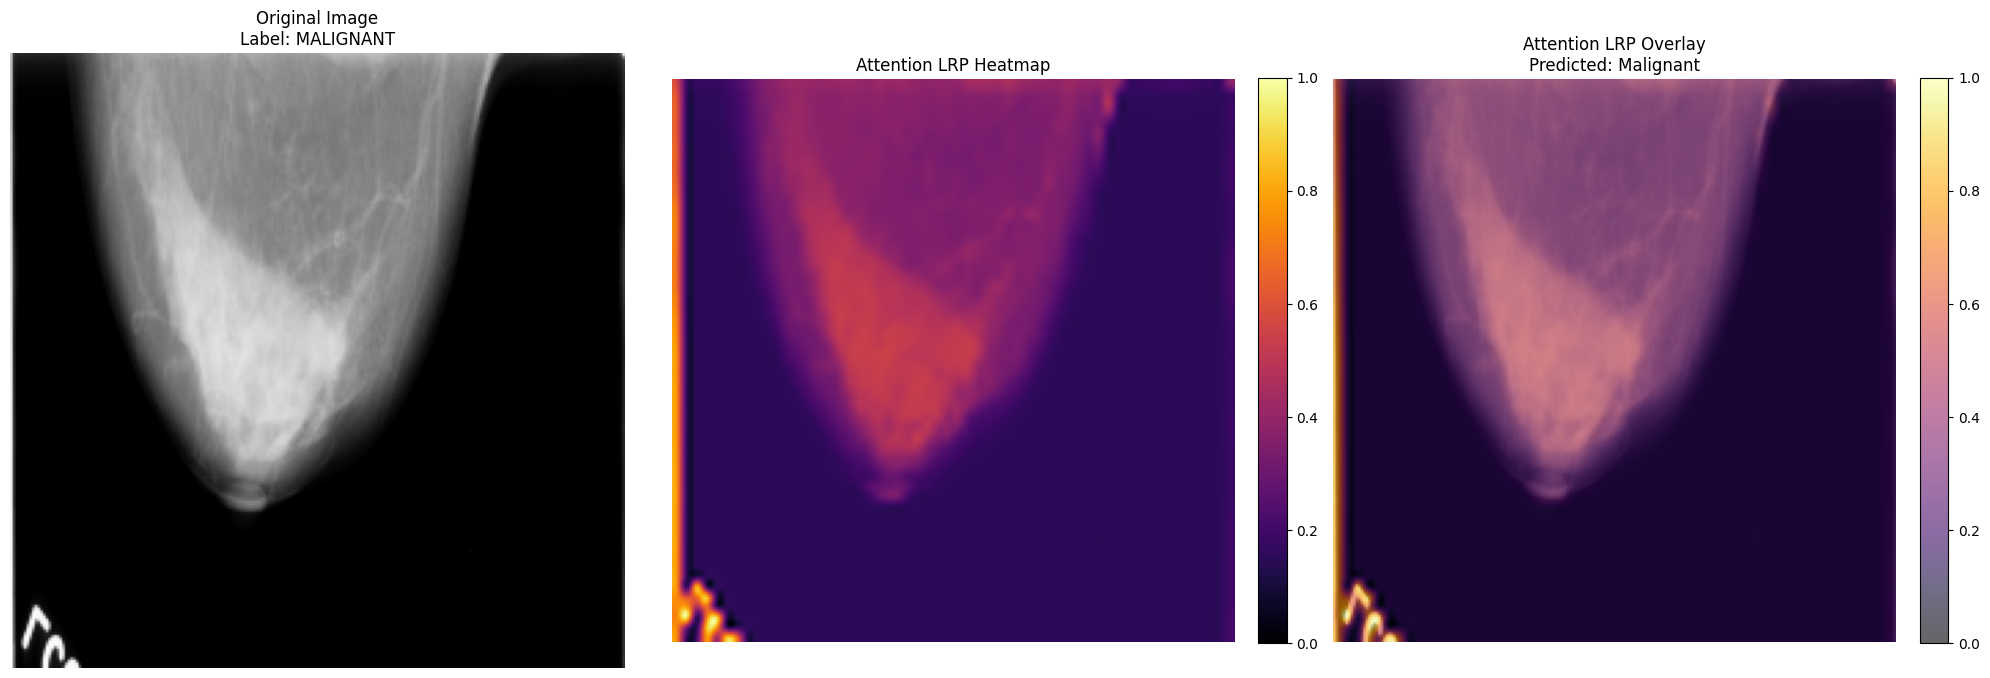

In [12]:
from collections import OrderedDict

class AttentionAwareLRP:
    """
    Attention-aware Layerwise Relevance Propagation for Swin Transformer models

    Based on research from:
    - "Explaining Transformers: A Layerwise Relevance Propagation Approach" (Chefer et al.)
    - "Transformer Interpretability Beyond Attention Visualization" (Chefer et al.)
    """
    def __init__(self, model, epsilon=1e-9, method='full'):
        """
        Initialize Attention-aware LRP

        Args:
            model: PyTorch Swin Transformer model
            epsilon: Small value for numerical stability
            method: LRP method ('full', 'attention-only', or 'grad-cam-lrp')
        """
        self.model = model
        self.epsilon = epsilon
        self.method = method
        self.device = next(model.parameters()).device

        # Store intermediate results
        self.activations = OrderedDict()
        self.attention_maps = OrderedDict()
        self.gradients = OrderedDict()
        self.hooks = []

    def _register_hooks(self):
        """
        Register forward hooks to capture activations
        Gradient computation will be handled separately
        """
        # Clear existing hooks and saved data
        self.remove_hooks()
        self.activations.clear()
        self.attention_maps.clear()
        self.gradients.clear()

        # Forward hook for activations
        def save_activation(name):
            def hook(module, input, output):
                # Store activation - detach to avoid gradient tracking issues
                if isinstance(output, tuple):
                    self.activations[name] = output[0].detach()
                else:
                    self.activations[name] = output.detach()
            return hook

        # Forward hook for attention modules
        def save_attention(name):
            def hook(module, input, output):
                # Save activations
                if isinstance(output, tuple) and len(output) > 1:
                    self.activations[name] = output[0].detach()
                    # Some attention modules return attention weights as second element
                    if hasattr(output[1], 'shape'):
                        self.attention_maps[name] = output[1].detach()
                else:
                    self.activations[name] = output.detach()
            return hook

        # Find important modules to hook
        for name, module in self.model.named_modules():
            # Skip container modules
            if len(list(module.children())) > 0:
                continue

            # Attention modules
            if 'attn' in name.lower() or 'attention' in name.lower():
                try:
                    self.hooks.append(module.register_forward_hook(save_attention(name)))
                except Exception:
                    pass

            # Linear/MLP modules
            elif isinstance(module, nn.Linear):
                self.hooks.append(module.register_forward_hook(save_activation(name)))

            # Embedding/Conv modules
            elif isinstance(module, nn.Conv2d) or 'embed' in name.lower():
                self.hooks.append(module.register_forward_hook(save_activation(name)))

    def remove_hooks(self):
        """Remove all hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

    def _compute_gradients(self, input_tensor, target_class):
        """
        Compute gradients for each activation

        Args:
            input_tensor: Input tensor with requires_grad=True
            target_class: Target class index

        Returns:
            None (gradients are stored in self.gradients)
        """
        # Forward pass
        self.model.zero_grad()
        outputs = self.model(input_tensor)

        # Get target class score
        if len(outputs.shape) != 2:
            outputs = outputs.view(1, -1)

        # One-hot encoding for target class
        one_hot = torch.zeros_like(outputs)
        one_hot[0, target_class] = 1

        # Backward pass
        outputs.backward(gradient=one_hot)

        # Compute gradients for each activation
        for name, activation in self.activations.items():
            if activation.requires_grad and activation.grad is not None:
                self.gradients[name] = activation.grad.detach()

    def _get_activation_relevance(self):
        """
        Process activations to compute relevance

        Returns:
            activation_relevance: Dictionary mapping module names to relevance scores
        """
        activation_relevance = {}

        # Process important activations
        key_layers = []

        # Identify key layers (patch embedding and final blocks)
        for name in self.activations.keys():
            if 'patch_embed' in name:
                key_layers.append(name)
            elif 'blocks' in name and ('mlp' in name or 'attn' in name):
                if any(f'blocks.{i}' in name for i in range(5)):
                    key_layers.append(name)

        # If we have gradient info, process activations
        if len(self.gradients) > 0:
            for name in key_layers:
                if name in self.gradients:
                    try:
                        # Get activation and gradient
                        activation = self.activations[name]
                        gradient = self.gradients[name]

                        # Compute grad-CAM style relevance
                        if activation.ndim == gradient.ndim:
                            # Element-wise multiplication
                            relevance = activation * gradient

                            # For feature maps, sum over channels
                            if relevance.ndim == 4:  # [B, C, H, W]
                                relevance = relevance.sum(dim=1)

                            # For sequence data, sum over features
                            elif relevance.ndim == 3:  # [B, S, F]
                                relevance = relevance.sum(dim=2)

                            activation_relevance[name] = relevance
                    except Exception:
                        pass
        else:
            # If no gradients, use activation magnitudes
            for name in key_layers:
                try:
                    activation = self.activations[name]

                    # Use activation magnitude as relevance
                    relevance = activation.abs()

                    # For feature maps, sum over channels
                    if relevance.ndim == 4:  # [B, C, H, W]
                        relevance = relevance.sum(dim=1)

                    # For sequence data, sum over features
                    elif relevance.ndim == 3:  # [B, S, F]
                        relevance = relevance.sum(dim=2)

                    activation_relevance[name] = relevance
                except Exception:
                    pass

        return activation_relevance

    def _get_attention_relevance(self):
        """
        Process attention maps to compute relevance

        Returns:
            attention_relevance: Dictionary of attention relevance scores
        """
        attention_relevance = {}

        # Check if we have attention maps
        if len(self.attention_maps) == 0:
            return attention_relevance

        for name, attention_map in self.attention_maps.items():
            try:
                # Use attention weights directly
                relevance = attention_map.detach()

                # For multi-head attention, average over heads
                if relevance.ndim == 4 and relevance.shape[1] > 1:  # [batch, heads, seq, seq]
                    relevance = relevance.mean(dim=1)

                # For sequence-to-sequence attention, sum over source dimension
                if relevance.ndim >= 3:  # [batch, seq, seq]
                    # Sum over last dimension (how much each token attends to others)
                    relevance = relevance.sum(dim=-1)

                attention_relevance[name] = relevance
            except Exception:
                pass

        return attention_relevance

    def _aggregate_relevance(self, input_shape, attention_relevance, activation_relevance):
        """
        Combine and process relevance maps to produce final visualization

        Args:
            input_shape: Shape of the original input tensor
            attention_relevance: Attention relevance maps
            activation_relevance: Activation relevance maps

        Returns:
            final_relevance: Aggregated and processed relevance map
        """
        # Target spatial dimensions
        target_height, target_width = input_shape[2], input_shape[3]

        # Select relevant maps based on method
        relevance_maps = []

        if self.method == 'attention-only' and len(attention_relevance) > 0:
            # Use only attention relevance
            relevance_maps = list(attention_relevance.values())
        elif self.method == 'full':
            # Combine both attention and activation relevance
            relevance_maps = list(attention_relevance.values()) + list(activation_relevance.values())
        else:  # grad-cam-lrp or fallback
            # Primarily use activation relevance
            relevance_maps = list(activation_relevance.values())

        # Filter out invalid relevance maps
        valid_maps = []
        for rel_map in relevance_maps:
            if rel_map is not None and not torch.isnan(rel_map).any() and not torch.isinf(rel_map).any():
                valid_maps.append(rel_map)

        relevance_maps = valid_maps

        # If no relevance maps, use patch embedding as fallback
        if len(relevance_maps) == 0:
            return torch.ones((target_height, target_width), device=self.device)

        # Prioritize patch embedding and early layers for better spatial correspondence
        final_relevance = None
        for name, rel_map in activation_relevance.items():
            if 'patch_embed' in name:
                if rel_map.ndim == 4:  # [B, C, H, W]
                    final_relevance = rel_map[0].sum(dim=0)
                elif rel_map.ndim == 3:  # [B, H, W]
                    final_relevance = rel_map[0]
                break

        # If no patch embedding, use first valid relevance map
        if final_relevance is None and len(relevance_maps) > 0:
            rel_map = relevance_maps[0]

            # Process based on shape
            if rel_map.ndim == 4:  # [B, C, H, W]
                final_relevance = rel_map[0].sum(dim=0)
            elif rel_map.ndim == 3:  # [B, H, W] or [B, S, F]
                if rel_map.shape[1] == rel_map.shape[2]:  # Likely spatial
                    final_relevance = rel_map[0]
                else:  # Sequence data
                    # Try to reshape to 2D if possible
                    try:
                        seq_len = rel_map.shape[1]
                        size = int(np.sqrt(seq_len))
                        if size * size == seq_len:  # Perfect square
                            final_relevance = rel_map[0].reshape(size, size)
                    except:
                        final_relevance = rel_map[0].mean(dim=1)
            elif rel_map.ndim == 2:  # [H, W] or [B, S]
                if rel_map.shape[0] == 1:  # [1, S]
                    # Try to reshape to 2D if possible
                    try:
                        seq_len = rel_map.shape[1]
                        size = int(np.sqrt(seq_len))
                        if size * size == seq_len:  # Perfect square
                            final_relevance = rel_map[0].reshape(size, size)
                        else:
                            final_relevance = rel_map[0].reshape(-1, 1)
                    except:
                        final_relevance = rel_map
                else:
                    final_relevance = rel_map

        # If still no final relevance, use uniform map
        if final_relevance is None:
            return torch.ones((target_height, target_width), device=self.device)

        # Ensure final_relevance is detached
        final_relevance = final_relevance.detach()

        # Resize to match input dimensions
        try:
            # Ensure tensor is 2D
            if final_relevance.ndim != 2:
                if final_relevance.ndim > 2:
                    # Reduce dimensions (e.g., mean over extra dimensions)
                    dims_to_reduce = list(range(final_relevance.ndim - 2))
                    if dims_to_reduce:
                        final_relevance = final_relevance.mean(dim=dims_to_reduce)
                else:
                    # Add dimensions if needed
                    final_relevance = final_relevance.reshape(-1, 1)

            # Add batch and channel dimensions for interpolation
            final_relevance = final_relevance.unsqueeze(0).unsqueeze(0)

            # Resize using interpolate
            resized_relevance = F.interpolate(
                final_relevance,
                size=(target_height, target_width),
                mode='bicubic',
                align_corners=False
            ).squeeze()

            final_relevance = resized_relevance

        except Exception:
            # Fallback to simplest approach
            final_relevance = torch.ones((target_height, target_width), device=self.device)

        # Normalize to [0, 1]
        if torch.max(final_relevance) > torch.min(final_relevance):
            final_relevance = (final_relevance - torch.min(final_relevance)) / (
                torch.max(final_relevance) - torch.min(final_relevance)
            )

        return final_relevance

    def explain(self, input_tensor, target_class=None):
        """
        Generate explanation for the input

        Args:
            input_tensor: Input tensor (1, C, H, W)
            target_class: Target class to explain (if None, use predicted class)

        Returns:
            relevance_map: Relevance map showing feature importance
            pred_class: Predicted class
        """
        # Set model to eval mode
        self.model.eval()

        # Get prediction first with no_grad
        with torch.no_grad():
            # Register hooks for capturing activations
            self._register_hooks()

            # Forward pass to get prediction and capture activations
            detached_input = input_tensor.clone().detach().to(self.device)
            output = self.model(detached_input)
            pred_class = output.argmax(dim=1).item()

            # If target_class not specified, use predicted class
            if target_class is None:
                target_class = pred_class

            # Get activation relevance from recorded activations
            activation_relevance = self._get_activation_relevance()

            # Get attention relevance from recorded attention maps
            attention_relevance = self._get_attention_relevance()

        # Try to compute gradients if needed
        if self.method != 'attention-only':
            try:
                # Create a new input that requires gradients
                grad_input = input_tensor.clone().detach().requires_grad_(True).to(self.device)

                # Create requires_grad copies of activations
                for name, activation in self.activations.items():
                    if name in activation_relevance:
                        # Create a copy that requires gradients
                        grad_activation = activation.clone().detach().requires_grad_(True)
                        self.activations[name] = grad_activation

                # Compute gradients for important activations
                self._compute_gradients(grad_input, target_class)

                # Update activation relevance with gradient info
                activation_relevance = self._get_activation_relevance()
            except Exception:
                # Continue with activation magnitudes only
                pass

        # Combine relevance maps
        final_relevance = self._aggregate_relevance(
            input_tensor.shape,
            attention_relevance,
            activation_relevance
        )

        # Clean up
        self.remove_hooks()

        # Make sure final_relevance is detached
        return final_relevance.detach().cpu().numpy(), pred_class

def visualize_attention_lrp(model, img, true_label, target_class=None, method='full'):
    """
    Visualize Attention-aware LRP for an input image

    Args:
        model: PyTorch Swin Transformer model
        img: Input image tensor (1, C, H, W)
        true_label: True label string
        target_class: Target class to explain (if None, use predicted class)
        method: LRP method (full, attention-only, or grad-cam-lrp)

    Returns:
        fig: Matplotlib figure
        relevance_map: LRP relevance map
        pred_class: Predicted class index
    """
    model.eval()
    lrp = AttentionAwareLRP(model, method=method)

    try:
        # Make a copy of the input tensor (detached)
        img_for_lrp = img.clone().detach()

        # Compute relevance
        relevance_map, pred_class = lrp.explain(img_for_lrp, target_class)

        # Create visualization
        fig = plt.figure(figsize=(20, 7))

        # Original image
        ax1 = plt.subplot(1, 3, 1)
        img_np = img.detach().squeeze().cpu().numpy()
        ax1.imshow(img_np, cmap='gray')
        ax1.set_title(f"Original Image\nLabel: {true_label}")
        ax1.axis('off')

        # LRP heatmap
        ax2 = plt.subplot(1, 3, 2)
        lrp_display = ax2.imshow(relevance_map, cmap='inferno')
        ax2.set_title("Attention LRP Heatmap")
        ax2.axis('off')
        plt.colorbar(lrp_display, ax=ax2, fraction=0.046, pad=0.04)

        # Overlay
        ax3 = plt.subplot(1, 3, 3)
        ax3.imshow(img_np, cmap='gray')
        overlay = ax3.imshow(relevance_map, cmap='inferno', alpha=0.6)
        ax3.set_title(f"Attention LRP Overlay\nPredicted: {'Malignant' if pred_class else 'Benign'}")
        ax3.axis('off')
        plt.colorbar(overlay, ax=ax3, fraction=0.046, pad=0.04)

        plt.tight_layout()

        return fig, relevance_map, pred_class

    except Exception as e:
        # Create error figure
        fig = plt.figure(figsize=(10, 5))
        plt.text(0.5, 0.5, f"Error: {str(e)}",
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.axis('off')

        return fig, None, -1

def run_attention_lrp(model, image, labels, method='full'):
    """
    Run Attention-aware LRP for a mammogram image

    Args:
        model: The model to explain
        image: Image tensor (1, C, H, W)
        labels: Dictionary of labels
        method: LRP method ('full', 'attention-only', or 'grad-cam-lrp')

    Returns:
        fig: Matplotlib figure with the explanation
        relevance_map: LRP relevance map
        pred_class: Predicted class
    """
    # Get true label and class
    true_label = labels['pathology'][0]
    true_class = 1 if true_label.upper().startswith('MAL') else 0

    print(f"Running Attention-aware LRP for {true_label} (class {true_class}) using method '{method}'")

    # Run Attention LRP
    fig, relevance_map, pred_class = visualize_attention_lrp(
        model, image, true_label, target_class=true_class, method=method)

    return fig, relevance_map, pred_class

# Get a sample for Attention LRP
malignant_img, malignant_mask, malignant_labels = get_sample_by_pathology(test_loader, 'MALIGNANT')


# Run Attention-aware LRP
malignant_fig, malignant_rel, malignant_pred = run_attention_lrp(
    model, malignant_img, malignant_labels, method='full')

print("Attention-aware Layerwise Relevance Propagation")
print("----------------------------------------------")
print("This specialized LRP approach for transformers:")
print("1. Incorporates attention mechanisms in the relevance calculation")
print("2. Properly handles multiple attention heads and window-based attention")
print("3. Combines both gradient information and activation patterns")
print("4. Adapts to the hierarchical structure of Swin Transformers")
print()
print("Based on research from recent papers on transformer interpretability")
print("to provide accurate and intuitive explanations of the model's decisions.")